## Introduction

New York City is one of the busiest urban areas in the world, with a transportation network that includes its iconic yellow and green taxis.

From two of the columns in this notebook, `lpep_pickup_datetime` and `lpep_dropoff_datetime`, in the context of NYC taxi data, LPEP stands for Livery Passenger Enhancement Program. It refers specifically to data collected from the green taxis, also known as Boro Taxis, which are part of the livery service authorized to pick up street-hail passengers in the outer boroughs and upper Manhattan. 
This notebook focuses on analyzing trip data from New York's green taxis, which primarily serve areas outside Manhattan, including the outer boroughs.

>Green taxis, also known as boro taxis and street-hail liveries, were introduced in August of 2013 to
>improve taxi service and availability in the boroughs. Green taxis may respond to street hails,
>but only in the areas indicated in green on the map (i.e. above W 110 St/E 96th St in Manhattan and in the boroughs).
>
>Source: [Trip Record User Guide](https://www.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf)

With an increase of ride-hailing apps like Uber and Lyft, the TLC has rolled out a new pilot program to phase out green taxis, called the SHL pilot program.


> **Street Hail Livery (SHL) Pilot Program**
> 
>The SHL Pilot Program utilizes returned SHL (Green Taxi) permits to test the feasibility of a license that cuts costs traditionally associated with SHLs, while also eliminating the ability to receive street hails. Over a period lasting no longer than two years, it will study potential improvements in pre arranged non-emergency medical transportation service, outer-borough service, fleet electrification, and wheelchair accessibility of the TLC fleet.
>
> ...
> 
> Operating Restrictions:
> 
> - The vehicle must be an Electric Vehicle (EV), a hybrid electric vehicle, or a Wheelchair Accessible Vehicle (WAV).
> - Unlike traditional SHLs, SHL Pilot Program participants may not accept street hails.
> - Similar to traditional SHLs, SHL Pilot Program participants may only accept trips beginning outside the Pre-Arranged Exclusionary Zone unless it is an Access A Ride or Medicaid-reimbursed trip.
>
> Source: [Street Hail Livery (SHL) Pilot Program](https://www.nyc.gov/site/tlc/about/shl-pilot-program.page)



>New York City's green taxis, known as "boro taxis," are being phased out due to a significant decline in their numbers and the evolving landscape of urban transportation. Introduced in 2013 to improve taxi access in the outer boroughs and upper Manhattan, the fleet has seen a dramatic reduction from over 6,500 vehicles in 2015 to fewer than 900 by 2023—a decrease of approximately 86%.
>
> Source: [Green Cabs Are Being Phased Out — Here's What Will Replace Them](https://www.nbcnewyork.com/news/local/green-cabs-are-being-phased-out-heres-what-will-replace-them/4302496)


## Problem Statement

Since the new program has a focus on pre-arranged trips only, and may not accept street hails. We want to know the trends in street-hail trips which the new SHL pilot program will erase.

1. What is the current fare like? What is the fare like during peak hours (surge pricing)?
2. What are popular pickup and drop off spots?
3. What are the customer payment preferences like?


In [1]:
# import modules

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import missingno as msno
import matplotlib.cm as cm
from statsmodels.stats.proportion import proportions_ztest
# import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [2]:
# read data
df = pd.read_csv('NYC TLC Trip Record.csv')

In [3]:
df.sample(10)

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
4853          2  2023-01-04 07:02:03   2023-01-04 07:10:57                  N   
24074         2  2023-01-12 23:59:09   2023-01-13 00:21:42                  N   
46382         2  2023-01-23 20:41:31   2023-01-23 20:54:06                  N   
32652         2  2023-01-17 14:03:33   2023-01-17 14:14:12                  N   
14960         2  2023-01-08 19:06:17   2023-01-08 19:22:18                  N   
15931         2  2023-01-09 11:54:41   2023-01-09 12:13:36                  N   
50352         2  2023-01-25 16:57:09   2023-01-25 17:16:05                  N   
40110         2  2023-01-20 18:30:12   2023-01-20 19:04:23                  N   
28806         2  2023-01-15 09:35:21   2023-01-15 09:39:54                  N   
49911         2  2023-01-25 14:29:34   2023-01-25 14:46:00                  N   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
4853          1.0            74            75              4.0           1.55   
24074         1.0            75           244              1.0           6.34   
46382         1.0            74           263              1.0           2.47   
32652         1.0            95           121              1.0           2.17   
14960         1.0            74           238              6.0           3.08   
15931         1.0           166           159              1.0           7.62   
50352         1.0            75           166              1.0           2.49   
40110         1.0           173           255              1.0           7.87   
28806         1.0            75           236              1.0           0.68   
49911         1.0            82           129              1.0           1.70   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
4853          10.7    0.0      0.5        2.44           0.0        NaN   
24074         29.6    1.0      0.5        0.01           0.0        NaN   
46382         14.9    1.0      0.5        5.04           0.0        NaN   
32652         13.5    0.0      0.5        0.00           0.0        NaN   
14960         17.7    0.0      0.5        5.49           0.0        NaN   
15931         34.5    0.0      0.5        0.00           0.0        NaN   
50352         18.4    2.5      0.5        3.50           0.0        NaN   
40110         41.5    2.5      0.5        0.00           0.0        NaN   
28806          7.2    0.0      0.5        2.29           0.0        NaN   
49911         15.6    0.0      0.5        0.00           0.0        NaN   

       improvement_surcharge  total_amount  payment_type  trip_type  \
4853                     1.0         14.64           1.0        1.0   
24074                    1.0         32.11           1.0        1.0   
46382                    1.0         25.19           1.0        1.0   
32652                    1.0         15.00           2.0        1.0   
14960                    1.0         27.44           1.0        1.0   
15931                    1.0         36.00           2.0        1.0   
50352                    1.0         25.90           1.0        1.0   
40110                    1.0         45.50           2.0        1.0   
28806                    1.0         13.74           1.0        1.0   
49911                    1.0         17.10           2.0        1.0   

       congestion_surcharge  
4853                   0.00  
24074                  0.00  
46382                  2.75  
32652                  0.00  
14960                  2.75  
15931                  0.00  
50352                  0.00  
40110                  0.00  
28806                  2.75  
49911                  0.00

In [4]:
# checking the overview of the data
display(df.info(), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

None

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4324
RatecodeID                4324
PULocationID                 0
DOLocationID                 0
passenger_count           4324
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                68211
improvement_surcharge        0
total_amount                 0
payment_type              4324
trip_type                 4334
congestion_surcharge      4324
dtype: int64

In [5]:
# check duplicates
df.duplicated().sum()

0

From this we can see that aside from the missing values and a column with no values at all, there are many columns with datatypes which are not appropriate to how they are interpreted, so we can change the column datatypes.

In [6]:
# changing data types

# datetimes
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

#categories
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
df['RatecodeID'] = df['RatecodeID'].astype('category') 
df['payment_type'] = df['payment_type'].astype('category')
df['trip_type'] = df['trip_type'].astype('category')
df['VendorID'] = df['VendorID'].astype('category')
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')

#int
df['passenger_count'] = df['passenger_count'].astype('Int64')


In [7]:
# check the datatypes have been changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  category      
 1   lpep_pickup_datetime   68211 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[ns]
 3   store_and_fwd_flag     63887 non-null  category      
 4   RatecodeID             63887 non-null  category      
 5   PULocationID           68211 non-null  category      
 6   DOLocationID           68211 non-null  category      
 7   passenger_count        63887 non-null  Int64         
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

### Functions to Calculate Outliers
These functions will help us calculate outliers when handling outliers later in the process.

In [8]:
# regular outliers
def outliers(data, column):
    """
    Calculate outliers in a column of data using the IQR method.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - column (str): The column name to check for outliers.

    Returns:
    - dict: A dictionary with   
        num_outliers: len(outliers),
        outlier_values: outliers[column].tolist(),
        outlier_indices: outliers.index.tolist(),
        lower_bound: lower_whisker,
        upper_bound: upper_whisker
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Determine outlier bounds
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[column] < lower_whisker) | (data[column] > upper_whisker)]

    return {
        "num_outliers": len(outliers),
        "outlier_values": outliers[column].tolist(),
        "outlier_indices": outliers.index.tolist(),
        "lower_bound": lower_whisker,
        "upper_bound": upper_whisker
    }


In [9]:
# extreme outliers
def extreme_outliers(data, column):
    """
    Calculate extreme outliers in a column of data using the IQR method.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - column (str): The column name to check for outliers.

    Returns:
    - dict: A dictionary with 
        num_extreme_outliers: len(outliers),
        extreme_outlier_values: outliers[column].tolist(),
        extreme_outlier_indices: outliers.index.tolist(),
        lower_bound: lower_whisker,
        upper_bound: upper_whisker
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range

    # Determine outlier bounds
    lower_whisker = Q1 - 3 * IQR
    upper_whisker = Q3 + 3 * IQR

    # Identify outliers
    outliers = data[(data[column] < lower_whisker) | (data[column] > upper_whisker)]

    return {
        "num_extreme_outliers": len(outliers),
        "extreme_outlier_values": outliers[column].tolist(),
        "extreme_outlier_indices": outliers.index.tolist(),
        "lower_bound": lower_whisker,
        "upper_bound": upper_whisker
    }


## Missing values and Outliers handling

### Drop Rows with Missing Values
Here we see that the columns containing missing values have the exact number of rows with missing values, so we want to find if there is a strong correlation between the columns with missing values. 

- From the heatmap below, it is known that the column with missing values have missing values in the same rows.
- This makes it more convenient to drop the missing values from these columns.
- We see form `df.info()` that the column `ehail_fee` contains 0 non-null values, giving us no information about the column. Hence, we are able to drop the column.

Columns with `6.34 - 6.35 %`missing values:
- `payment_type`             
- `trip_type`            
- `congestion_surcharge` 
- `passenger_count`  
- `store_and_fwd_flag`    
- `RatecodeID`


In [10]:
# percentage of missing values per column
round(100*df.isna().sum()/len(df), 2)

VendorID                   0.00
lpep_pickup_datetime       0.00
lpep_dropoff_datetime      0.00
store_and_fwd_flag         6.34
RatecodeID                 6.34
PULocationID               0.00
DOLocationID               0.00
passenger_count            6.34
trip_distance              0.00
fare_amount                0.00
extra                      0.00
mta_tax                    0.00
tip_amount                 0.00
tolls_amount               0.00
ehail_fee                100.00
improvement_surcharge      0.00
total_amount               0.00
payment_type               6.34
trip_type                  6.35
congestion_surcharge       6.34
dtype: float64

<Figure size 500x200 with 0 Axes>

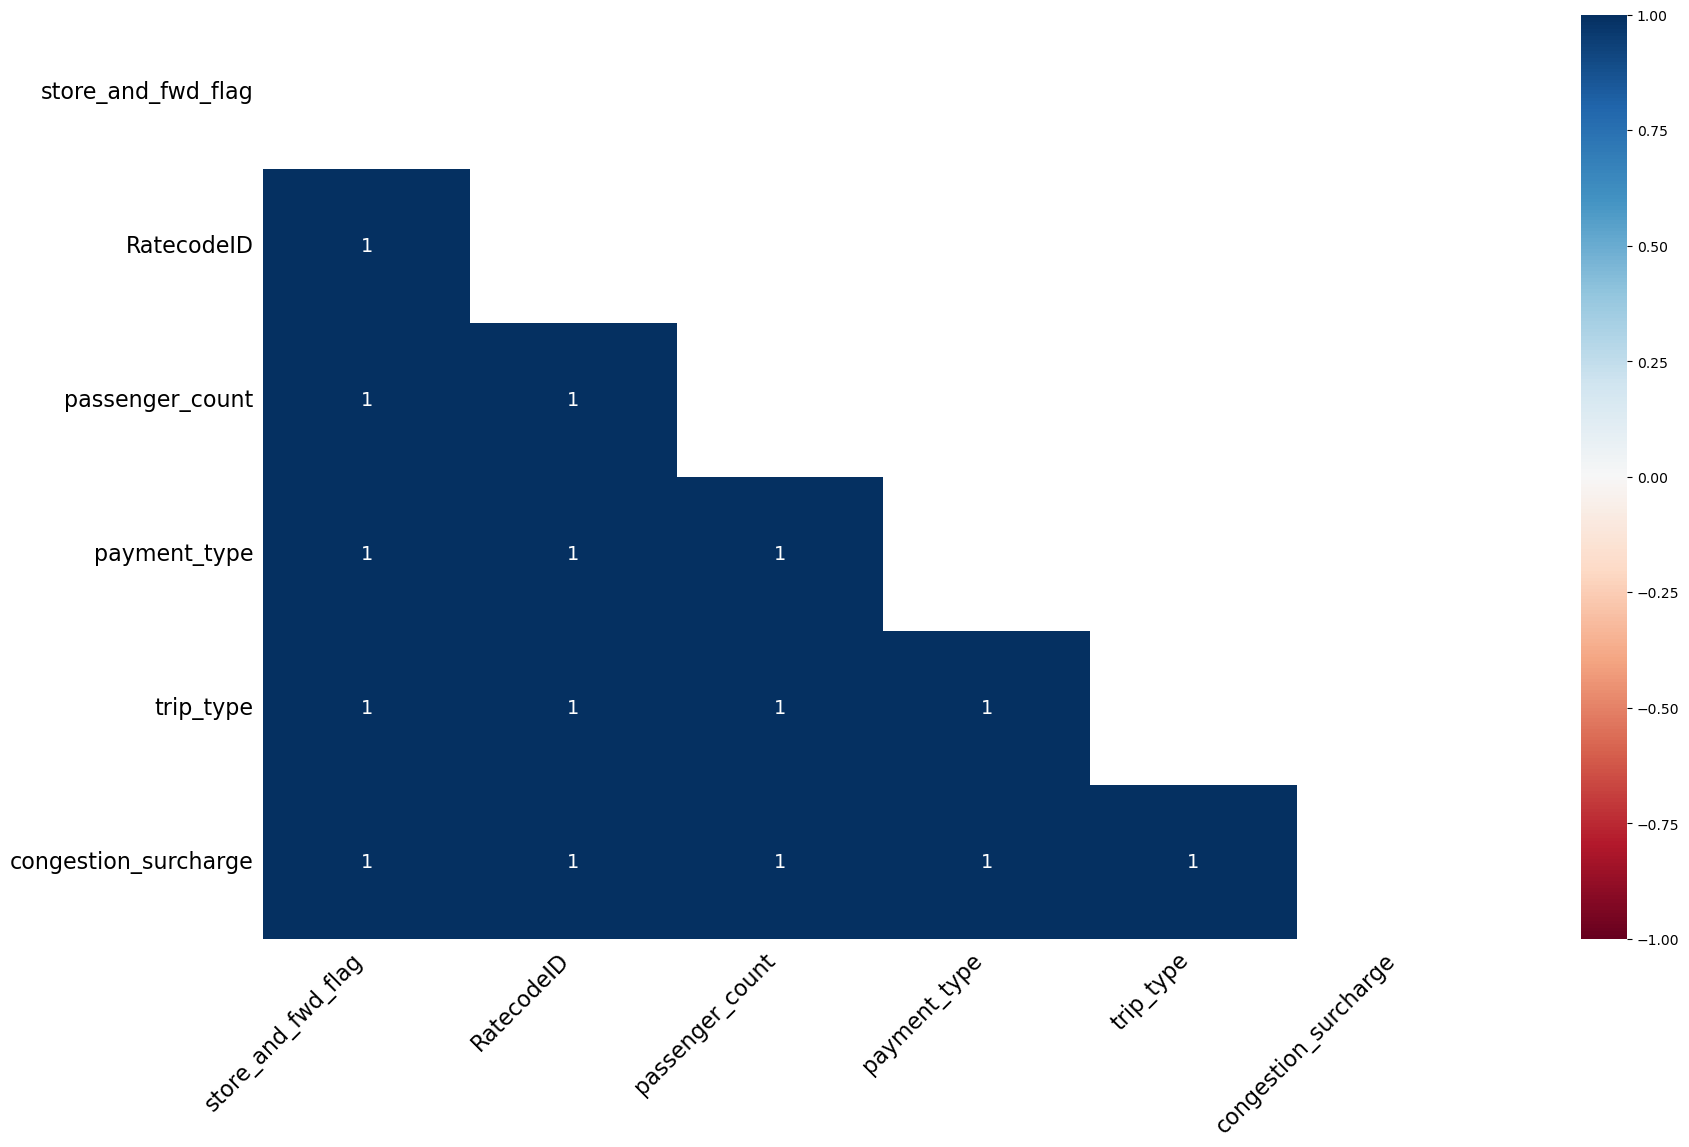

In [11]:
plt.figure(figsize=(5, 2))
msno.heatmap(df)
plt.show()

In [12]:
# drop e-hail fee
df = df.drop(columns=['ehail_fee'])

In [13]:
# Drop rows with missing values
df = df.dropna(subset="trip_type")

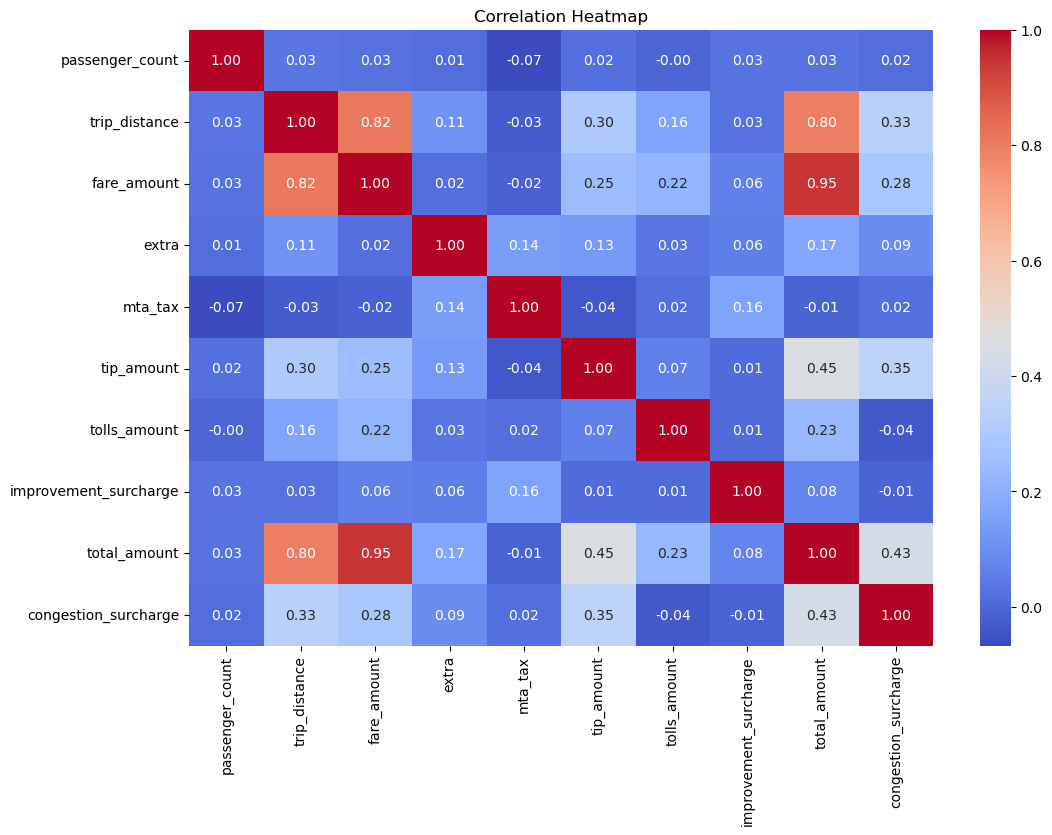

In [14]:
# Calculate the correlation matrix
correlation_matrix = df.corr(method='spearman', numeric_only=True)

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

plt.title('Correlation Heatmap')
plt.show()

In [15]:
df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
dtype: int64

### 1. `total_amount`

**Description:**
>
>The total amount charged to passengers. Does not include cash tips.
>
>$3.00 initial charge.
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
>
**Summary:**
+ Take absolute values of the values in the column since a negative total amount does not make sense.
+ Since there is a minimum charge of 3.00 dollars, we can assume there is an error if `total_amount`< 3.00 dollars

In [16]:
df['total_amount'].describe()

count    63877.000000
mean        21.200955
std         15.131310
min        -71.500000
25%         12.600000
50%         17.500000
75%         25.500000
max        491.000000
Name: total_amount, dtype: float64

In [17]:
# taking absolute values to eliminate negative values
df['total_amount'] = abs(df['total_amount'])

In [18]:
# filtering a minimum of 3 dollars
df = df[df['total_amount']>=3]

In [19]:
df['total_amount'].describe()

count    63793.000000
mean        21.275094
std         15.056566
min          3.000000
25%         12.600000
50%         17.500000
75%         25.500000
max        491.000000
Name: total_amount, dtype: float64

<Axes: ylabel='total_amount'>

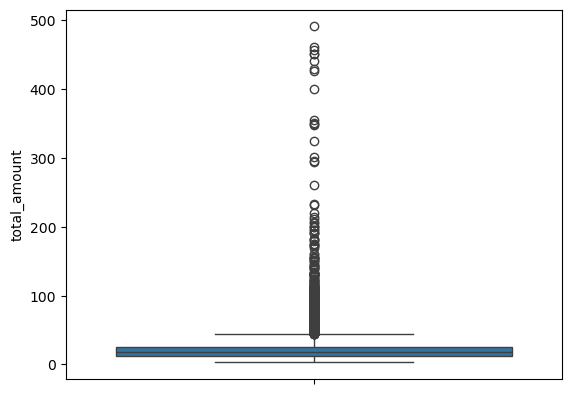

In [20]:
sns.boxplot(df['total_amount'])

In [21]:
#looking at the outliers
df[df['total_amount']>200]['RatecodeID'].value_counts()

RatecodeID
5.0     13
4.0      7
1.0      6
2.0      0
3.0      0
99.0     0
Name: count, dtype: int64

we see that some of the outliers have a `RatecodeID` value of 5, which indicates a negotiated fare. There also might be an error, like having a zero `trip_distance` so we need to see its correlation wi

### 2. `fare_amount`

**Description:**
>
>The time-and-distance fare calculated by the meter.
>
>$3.00 initial charge.
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
>
**Summary:**
+ Take absolute values of the values in the column since a negative total amount does not make sense.
+ Since there is a minimum charge of 3.00 dollars, we can assume there is an error if `total_amount`< 3.00 dollars

In [22]:
df['fare_amount'].describe()

count    63793.000000
mean        16.095604
std         13.273118
min        -70.000000
25%          9.300000
50%         12.800000
75%         19.100000
max        490.000000
Name: fare_amount, dtype: float64

In [23]:
# taking absolute values to eliminate negative values
df['fare_amount'] = abs(df['fare_amount'])

In [24]:
# filtering a minimum of 3 dollars
df = df[df['fare_amount']>=3]

<Axes: ylabel='fare_amount'>

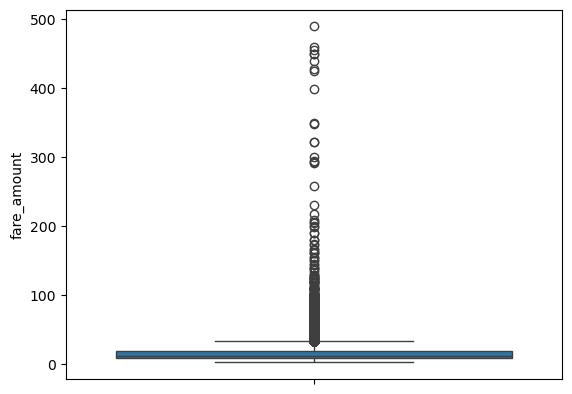

In [25]:
sns.boxplot(df['fare_amount'])

In [26]:
df[df['fare_amount']>200]

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
556          2  2023-01-01 13:07:46   2023-01-01 19:45:18                  N   
2014         2  2023-01-02 15:36:45   2023-01-02 20:44:45                  N   
7731         2  2023-01-05 12:12:49   2023-01-05 19:53:49                  N   
7906         2  2023-01-05 13:36:05   2023-01-05 13:38:10                  N   
12602        2  2023-01-07 15:57:20   2023-01-07 15:57:24                  N   
12615        2  2023-01-07 15:55:53   2023-01-07 20:38:53                  N   
18474        2  2023-01-10 15:58:15   2023-01-10 15:58:26                  N   
21547        2  2023-01-11 20:52:23   2023-01-11 20:52:33                  N   
25518        2  2023-01-13 16:51:53   2023-01-13 18:37:48                  N   
30047        2  2023-01-15 21:57:15   2023-01-15 21:57:20                  N   
30070        2  2023-01-15 22:37:11   2023-01-15 22:37:14                  N   
33098        2  2023-01-17 16:59:25   2023-01-17 18:23:13                  N   
42278        2  2023-01-21 19:47:15   2023-01-21 19:51:20                  N   
42882        2  2023-01-22 05:14:42   2023-01-22 06:15:40                  N   
43013        2  2023-01-22 10:39:49   2023-01-22 11:48:18                  N   
44927        2  2023-01-23 10:28:05   2023-01-23 11:33:51                  N   
46373        2  2023-01-23 20:43:48   2023-01-23 20:43:53                  N   
50437        2  2023-01-25 17:24:38   2023-01-25 19:16:52                  N   
50526        2  2023-01-25 17:14:16   2023-01-25 17:21:43                  N   
53670        2  2023-01-26 21:26:12   2023-01-26 21:26:17                  N   
59442        2  2023-01-29 20:01:58   2023-01-29 20:05:25                  N   
61656        2  2023-01-30 22:13:19   2023-01-30 22:13:32                  N   
62314        2  2023-01-31 11:26:06   2023-01-31 12:19:14                  N   

      RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
556          1.0          223            8                1          16.00   
2014         1.0          223          223                1           2.35   
7731         1.0          223          223                1          25.48   
7906         5.0           92           92                1           0.00   
12602        5.0          130          130                1           0.00   
12615        1.0          223          223                1          20.43   
18474        5.0           92           92                1           0.38   
21547        5.0          130          130                1           0.00   
25518        4.0          265           92                2          38.24   
30047        5.0          191          191                1           0.00   
30070        5.0          265          265                3           0.00   
33098        4.0           28          265                2          36.40   
42278        5.0           92           92                1           0.00   
42882        4.0          112          265                2          35.39   
43013        1.0           82          265                1          57.09   
44927        4.0           95          265                1          47.25   
46373        5.0          130          130                1           0.00   
50437        4.0           82          265                5          46.29   
50526        5.0           80           37                1           0.60   
53670        5.0          129          129                1           0.00   
59442        5.0           92           92                1           0.07   
61656        5.0           82           82                1           0.02   
62314        4.0          130          265                1          48.19   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
556          292.8    0.0      0.5         0.0           0.0   
2014         218.6    0.0      0.5         0.0           0.0   
7731         348.1  

<Axes: xlabel='total_amount', ylabel='fare_amount'>

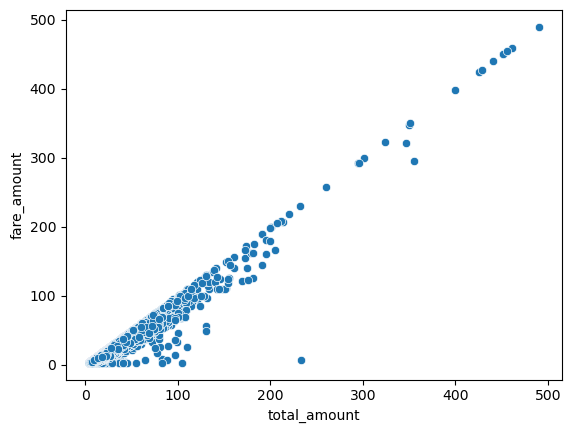

In [27]:
sns.scatterplot(df, x='total_amount', y='fare_amount')

### 3. `trip_distance`

**Description:**
>
>The elapsed trip distance in miles reported by the taximeter.
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
**Summary:**
+ Find outliers and erase them from our data

In [28]:
df['trip_distance'].describe()

count    63715.000000
mean         2.579384
std          6.761230
min          0.000000
25%          1.100000
50%          1.800000
75%          3.060000
max       1571.970000
Name: trip_distance, dtype: float64

<Axes: ylabel='trip_distance'>

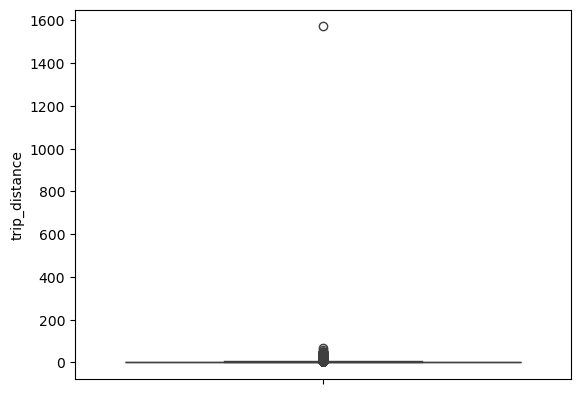

In [29]:
sns.boxplot(df['trip_distance'])

There is an extreme outlier value at 1571.97 miles, this distance does not seem likely to be covered by a taxi trip, so we will exclude it.

In [30]:
df = df[df['trip_distance']<200]

<Axes: ylabel='trip_distance'>

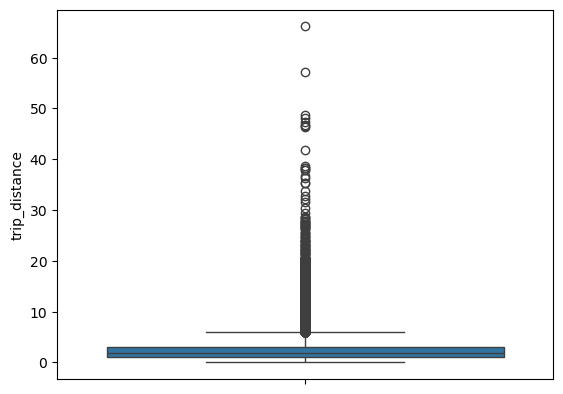

In [31]:
sns.boxplot(df['trip_distance'])

### 4. `lpep_pickup_datetime` and `lpep_dropoff_datetime`

**Description:**
>
>`lpep_pickup_datetime`: The date and time when the meter was engaged.
>
>`lpep_dropoff_datetime`: The date and time when the meter was disengaged. 
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
**Summary:**
+ Find outliers and erase them from our data
+ Find contextual outliers by making and calculating another column named `trip_duration`

In [32]:
df[['lpep_pickup_datetime', 'lpep_dropoff_datetime']].describe()

lpep_pickup_datetime          lpep_dropoff_datetime
count                          63714                          63714
mean   2023-01-16 20:29:24.513670400  2023-01-16 20:47:18.131321088
min              2009-01-01 20:21:27            2009-01-02 11:07:31
25%       2023-01-09 12:11:43.500000     2023-01-09 12:31:23.500000
50%              2023-01-17 08:45:12            2023-01-17 08:59:47
75%    2023-01-24 16:18:43.249999872  2023-01-24 16:36:50.249999872
max              2023-02-01 03:10:05            2023-02-01 17:27:05

Here we see that most of our data (median, quantiles) are centered around January 2023, but there is an outlier in the minimum value of both pickup and datetime. We now calculate other outliers and view the min and max again after dropping the outlier.

In [33]:
# finding and dropping outliers
pu_outliers = outliers(df,'lpep_pickup_datetime')
df = df.drop(index=pu_outliers['outlier_indices'])

do_outliers = outliers(df,'lpep_dropoff_datetime')
df = df.drop(index=do_outliers['outlier_indices'])

In [34]:
df[['lpep_pickup_datetime', 'lpep_dropoff_datetime']].describe()

lpep_pickup_datetime          lpep_dropoff_datetime
count                          63711                          63711
mean   2023-01-16 22:27:02.459951872  2023-01-16 22:44:55.247539456
min              2023-01-01 00:01:31            2023-01-01 00:13:26
25%       2023-01-09 12:13:20.500000            2023-01-09 12:31:59
50%              2023-01-17 08:45:18            2023-01-17 09:00:04
75%       2023-01-24 16:18:56.500000            2023-01-24 16:37:00
max              2023-02-01 03:10:05            2023-02-01 17:27:05

We find that our data occurs in the range `01 January 2023` to `01 February 2023`.

There is another piece of information which we can get from these two columns, which is the total duration of the trip. We can make a new column called `trip_duration` using the difference between dropoff and pickup time in minutes, and look for trip duration outliers.

In [35]:
df['trip_duration'] = round((df['lpep_dropoff_datetime']-df['lpep_pickup_datetime']).dt.total_seconds() / 60, 2)

In [36]:
df['trip_duration'].describe()

count    63711.000000
mean        17.879798
std         76.338399
min          0.000000
25%          7.100000
50%         11.120000
75%         16.900000
max       1438.930000
Name: trip_duration, dtype: float64

We see that there are no negative durations, which is good, however there is an outlier in the maximum value, so we have to look for outliers and drop the rows if we need to.

<Axes: ylabel='trip_duration'>

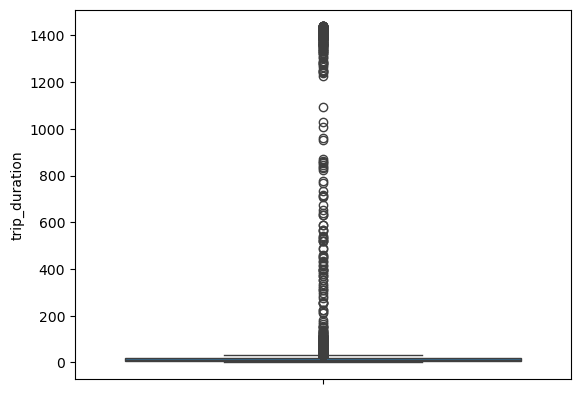

In [37]:
sns.boxplot(df['trip_duration'])

We see that there are quite a few outliers, we print the rows of the outliers to see if they have anything in common.

In [38]:
df.loc[extreme_outliers(df, 'trip_duration')['extreme_outlier_indices']]

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
49           2  2023-01-01 00:23:04   2023-01-01 23:18:32                  N   
57           2  2023-01-01 00:06:48   2023-01-01 01:08:47                  N   
101          2  2023-01-01 01:30:39   2023-01-01 02:20:23                  N   
108          2  2023-01-01 01:53:59   2023-01-02 00:00:00                  N   
118          2  2023-01-01 01:25:46   2023-01-02 00:29:15                  N   
...        ...                  ...                   ...                ...   
63263        2  2023-01-31 18:06:46   2023-01-31 18:55:03                  N   
63279        2  2023-01-31 18:22:24   2023-02-01 00:00:00                  N   
63314        1  2023-01-31 18:01:07   2023-01-31 18:52:57                  N   
63462        2  2023-01-31 19:40:22   2023-02-01 00:00:00                  N   
63611        2  2023-01-31 20:46:22   2023-01-31 21:34:57                  N   

      RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
49           1.0          255           48                1           8.55   
57           1.0          129          226                2           7.83   
101          5.0           80          145                2          14.97   
108          1.0          260          223                1           2.64   
118          1.0          129           37                1           6.53   
...          ...          ...          ...              ...            ...   
63263        1.0           65          124                1           8.52   
63279        1.0           82           82                1           1.46   
63314        1.0          210          210                1           7.30   
63462        1.0          226          173                1           2.94   
63611        1.0           71          180                1           7.89   

       fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
49            47.8    1.0      0.5         5.3           0.0   
57            52.0    1.0      0.5         0.0           0.0   
101           50.0    0.0      0.0         0.0           0.0   
108           14.9    1.0      0.5         0.0           0.0   
118           31.0    1.0      0.5         0.0           0.0   
...            ...    ...      ...         ...           ...   
63263         45.7    2.5      0.5         0.0           0.0   
63279         10.7    2.5      0.5         0.0           0.0   
63314         42.2    2.5      1.5         0.0           0.0   
63462         14.9    2.5      0.5         0.0           0.0   
63611         48.5    1.0      0.5         0.0           0.0   

       improvement_surcharge  total_amount payment_type trip_type  \
49                       1.0         58.35          1.0       1.0   
57                       1.0         54.50          2.0       1.0   
101                      1.0         53.75          2.0       2.0   
108                      1.0         17.40          1.0       1.0   
118                      1.0         33.50          2.0       1.0   
...                      ...           ...          ...       ...   
63263                    1.0         49.70          1.0       1.0   
63279                    1.0         14.70          2.0       1.0   
63314                    1.0         46.20          2.0       1.0   
63462                    1.0         18.90          2.0       1.0   
63611                    1.0         51.00          2.0       1.0   

       congestion_surcharge  trip_duration  
49                     2.75        1375.47  
57                     0.00          61.98  
101                    2.75          49.73  
108                    0.00        1326.02  
118                    0.00        1383.48  
...                     ...            ...  
63263                  0.00          48.28  
63279                  0.00         337.60  
63314                  0.00          51.83  
63462                  0.00         259.63  
63611          

there are still many "extreme" outliers with durations which still makes sense, such as 49, 61, 51 minutes.

### Contextual Outliers between `trip_duration`, `trip_distance`, `total_amount`, `fare_amount` 

Since there are many outlier values having `RatecodeID = 5` which indicates a negotiated fare, we are going to drop these values from the main dataframe, but keep a copy to investigate later.

In [39]:
# drop RatecodeID = 5
df_nego_fare = df.copy()
df_nego_fare = df_nego_fare[df_nego_fare['RatecodeID']==5]

df = df[df['RatecodeID']!=5]

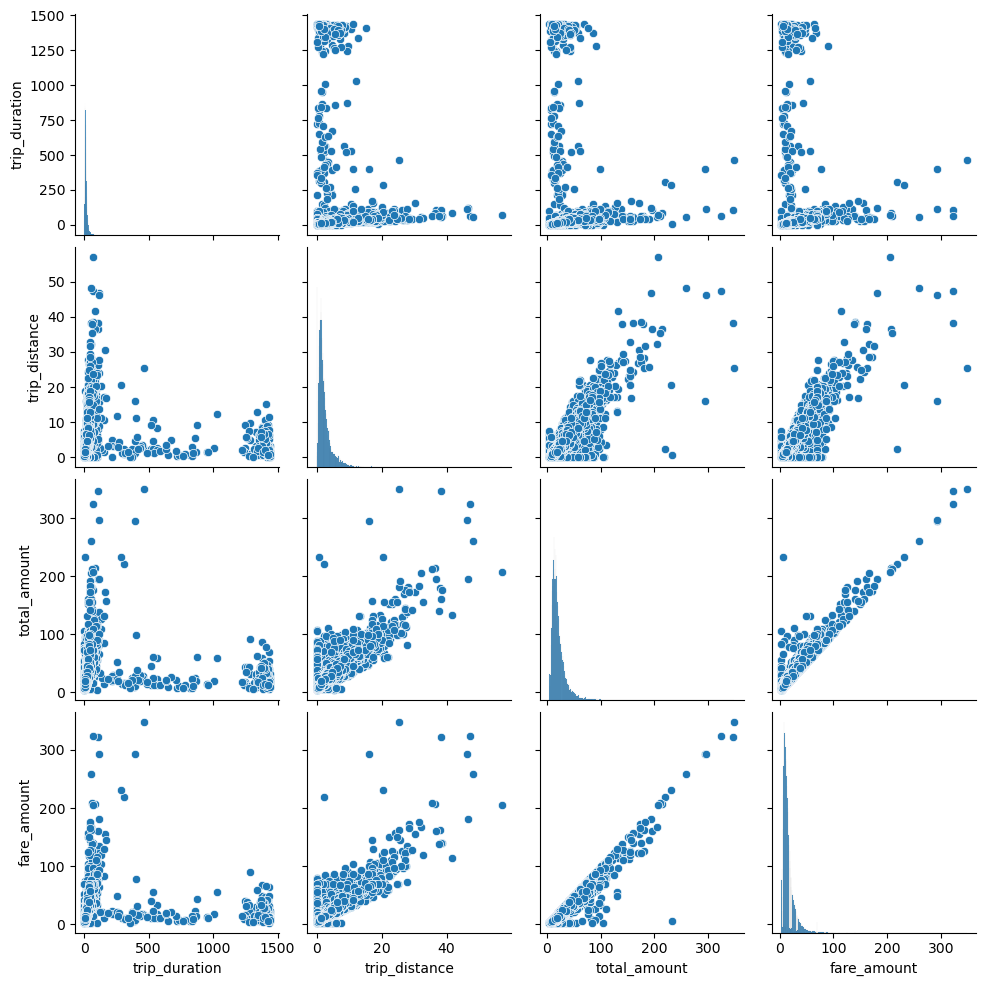

In [40]:
sns.pairplot(data=df, vars= ['trip_duration', 'trip_distance', 'total_amount', 'fare_amount'])

In [41]:
df[['trip_duration', 'trip_distance', 'total_amount', 'fare_amount']].corr()

trip_duration  trip_distance  total_amount  fare_amount
trip_duration       1.000000       0.102998      0.122978     0.133310
trip_distance       0.102998       1.000000      0.863932     0.867497
total_amount        0.122978       0.863932      1.000000     0.960678
fare_amount         0.133310       0.867497      0.960678     1.000000

There seems to be a divide in the plots where there is a long trip duration, so we can investigate this further

In [42]:
# dropping rows wiht trip duration >200 minutes (3.33 hours)
df = df[df['trip_duration']<200]

In [43]:
# dropping rows with 0 values from trip_distance, but keeping true zeros
df = df[~((df['trip_distance']==0) & (df['fare_amount']>3))]

In [44]:
# dropping rows with 0 trip_duration
df = df[df['trip_duration']>0]

In [45]:
df[(df['trip_distance']>0)&(df['trip_duration']<0.1)]

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
35           1  2023-01-01 00:41:53   2023-01-01 00:41:58                  N   
146          2  2023-01-01 02:03:52   2023-01-01 02:03:57                  N   
717          2  2023-01-01 15:21:15   2023-01-01 15:21:20                  N   
794          2  2023-01-01 16:20:22   2023-01-01 16:20:24                  N   
1948         2  2023-01-02 14:32:32   2023-01-02 14:32:37                  N   
3128         1  2023-01-03 09:10:16   2023-01-03 09:10:18                  N   
8682         2  2023-01-05 18:25:49   2023-01-05 18:25:53                  N   
10794        1  2023-01-06 17:48:21   2023-01-06 17:48:26                  N   
11606        2  2023-01-06 23:59:07   2023-01-06 23:59:11                  N   
11688        2  2023-01-07 01:29:51   2023-01-07 01:29:53                  N   
11889        2  2023-01-07 08:57:11   2023-01-07 08:57:14                  N   
11890        2  2023-01-07 08:57:11   2023-01-07 08:57:14                  N   
12208        2  2023-01-07 12:00:48   2023-01-07 12:00:49                  N   
12463        2  2023-01-07 14:32:13   2023-01-07 14:32:17                  N   
14601        1  2023-01-08 16:09:42   2023-01-08 16:09:47                  N   
16801        2  2023-01-09 17:47:06   2023-01-09 17:47:08                  N   
16846        2  2023-01-09 18:41:29   2023-01-09 18:41:31                  N   
17954        2  2023-01-10 11:42:50   2023-01-10 11:42:55                  N   
18433        2  2023-01-10 15:29:08   2023-01-10 15:29:10                  N   
20214        1  2023-01-11 12:06:50   2023-01-11 12:06:51                  N   
20898        2  2023-01-11 16:08:42   2023-01-11 16:08:47                  N   
22446        2  2023-01-12 11:04:59   2023-01-12 11:05:01                  N   
22600        2  2023-01-12 12:26:24   2023-01-12 12:26:27                  N   
22601        2  2023-01-12 12:26:24   2023-01-12 12:26:27                  N   
24333        2  2023-01-13 07:24:46   2023-01-13 07:24:50                  N   
28626        1  2023-01-15 03:28:15   2023-01-15 03:28:17                  N   
29253        2  2023-01-15 14:16:38   2023-01-15 14:16:43                  N   
34226        2  2023-01-18 09:46:05   2023-01-18 09:46:09                  N   
35528        2  2023-01-18 18:11:14   2023-01-18 18:11:19                  N   
35529        2  2023-01-18 18:11:14   2023-01-18 18:11:19                  N   
36093        2  2023-01-19 07:08:11   2023-01-19 07:08:13                  N   
40402        2  2023-01-20 20:00:42   2023-01-20 20:00:47                  N   
41047        1  2023-01-21 10:52:10   2023-01-21 10:52:14                  N   
43269        2  2023-01-22 13:13:49   2023-01-22 13:13:51                  N   
45120        1  2023-01-23 12:25:35   2023-01-23 12:25:39                  N   
46254        2  2023-01-23 19:35:26   2023-01-23 19:35:30                  N   
52250        2  2023-01-26 13:56:31   2023-01-26 13:56:32                  N   
56508        2  2023-01-28 09:13:38   2023-01-28 09:13:43                  N   
57230        2  2023-01-28 16:48:59   2023-01-28 16:49:01                  N   
61639        2  2023-01-30 23:01:01   2023-01-30 23:01:06                  N   
61883        2  2023-01-31 07:51:30   2023-01-31 07:51:35                  N   
63282        2  2023-01-31 18:58:27   2023-01-31 18:58:32                  N   

      RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
35           1.0           83           83                1           6.70   
146          1.0          169          169                2           0.01   
717          2.0           75           75                1           0.01   
794          1.0           42          264                1           0.02   
1948         1.0           92           92                1           0.03   
3128         1.0           74           74                6           6.50   
8682         1.0   

<Axes: xlabel='trip_distance', ylabel='trip_duration'>

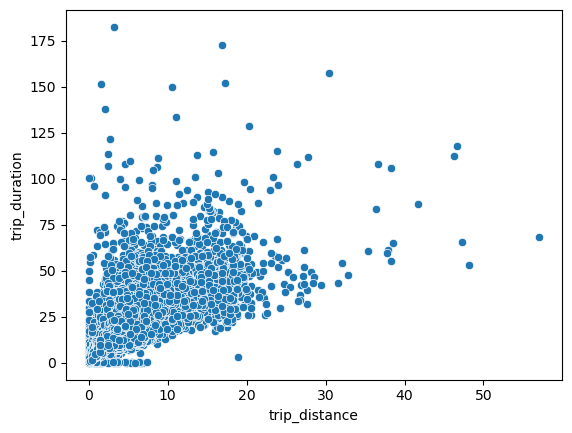

In [46]:
sns.scatterplot(df, x='trip_distance', y='trip_duration')

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

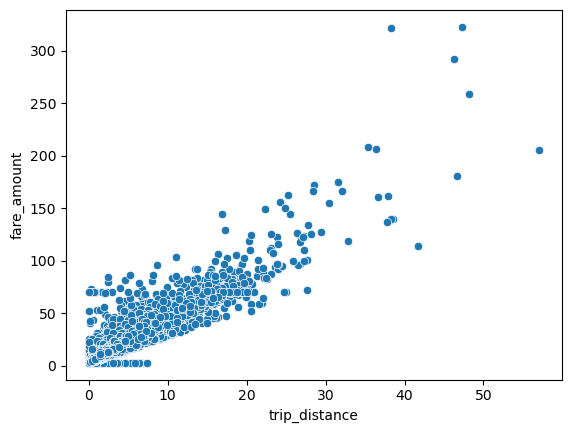

In [47]:
sns.scatterplot(df, x='trip_distance', y='fare_amount')

<Axes: xlabel='trip_distance', ylabel='total_amount'>

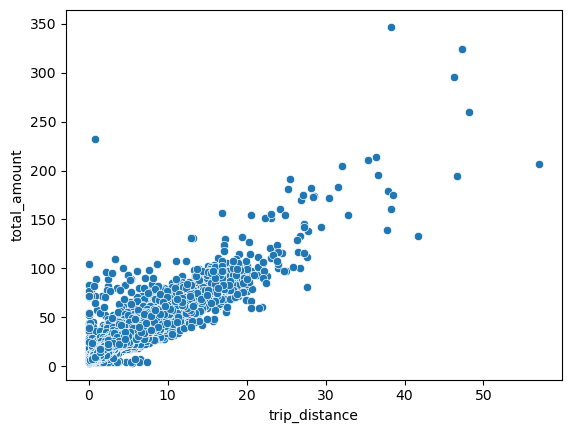

In [48]:
sns.scatterplot(df, x='trip_distance', y='total_amount')

<Axes: xlabel='trip_duration', ylabel='fare_amount'>

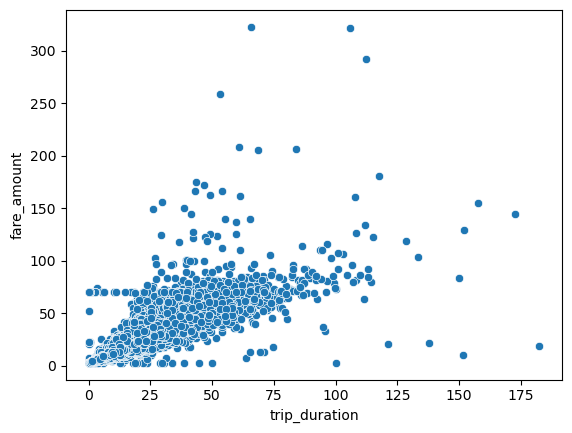

In [49]:
sns.scatterplot(df, x='trip_duration', y='fare_amount')

### Calculated Total Amount

To know if there is an error in the various columns which contribute to the total amount, a new column called `calc_amount` is made.
The column is the sum of the values in the columns: `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge`, and `congestion_surcharge`

In [50]:
def calculate_diff():
    df['calc_amount'] = df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['improvement_surcharge'] + df['congestion_surcharge']
    df['diff_amount'] = round(df['total_amount'] - df['calc_amount'], 5)

In [51]:
calculate_diff()

In [52]:
df['diff_amount'].value_counts()

diff_amount
 0.00     52056
-1.00      5388
-3.75      2325
 3.00        66
 8.00        44
 5.00        28
-2.75        10
 1.95         6
 4.80         5
 1.60         3
 1.25         1
 3.02         1
 24.00        1
 13.50        1
 8.50         1
Name: count, dtype: int64

In [53]:
df[df['diff_amount']==-1][['total_amount', 'calc_amount', 'diff_amount']]

total_amount  calc_amount  diff_amount
3             10.20        11.20         -1.0
4              8.00         9.00         -1.0
15            34.50        35.50         -1.0
35             5.50         6.50         -1.0
65            10.00        11.00         -1.0
...             ...          ...          ...
63823          9.70        10.70         -1.0
63840         11.85        12.85         -1.0
63843         18.35        19.35         -1.0
63844         20.85        21.85         -1.0
63846         11.80        12.80         -1.0

[5388 rows x 3 columns]

### 5. `mta_tax`

**Description:**

> Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
>
>Source: [Taxi Fare](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)
>
**Summary:**
+ Get absolute value, since a negative surcharge should be read as an error

In [54]:
df['mta_tax'].value_counts()

mta_tax
 0.5    52046
 1.5     7710
-0.5      150
 0.0       27
 1.0        3
Name: count, dtype: int64

In [55]:
# get absolute values
df['mta_tax'] = abs(df['mta_tax'])

In [56]:
df[df['mta_tax']==1.5]['diff_amount'].value_counts()

diff_amount
-1.00    5385
-3.75    2325
Name: count, dtype: int64

We can see that the from the `diff_amount` there could be an error in the `mta_tax` input which causes a difference in the total and calculated amount, so for these values we can change the `mta_tax` to 50 cents as per the fare rules.

In [57]:
df['mta_tax'] = np.where(df['mta_tax']==1.5, 0.5, df['mta_tax'])

In [58]:
df['mta_tax'].value_counts()

mta_tax
0.5    59906
0.0       27
1.0        3
Name: count, dtype: int64

In [59]:
df[df['mta_tax']==1]['diff_amount'].value_counts()

diff_amount
-1.0    3
Name: count, dtype: int64

with the `diff_amount` being -1.00 USD for all the rows with 1.00 mta tax, we can assume that there was an error and these trips do not incur the 50 cent mta tax.

In [60]:
df['mta_tax'] = np.where(df['mta_tax']==1, 0, df['mta_tax'])

In [61]:
calculate_diff()

In [62]:
df['diff_amount'].value_counts()

diff_amount
 0.00     57444
-2.75      2335
 2.00        66
 7.00        44
 4.00        28
 1.95         6
 3.80         5
 0.60         3
 1.25         1
 2.02         1
 23.00        1
 12.50        1
 7.50         1
Name: count, dtype: int64

### 6. `passenger_count`

**Description:**
>The number of passengers in the vehicle.
>This is a driver-entered value.
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
**Summary:**
+ Update the values with `passenger_count` of `0` to `1` since it is a driver-entered value and can be contributed to driver error, so the mode is imputed since the distribution is skewed to passenger count 1, and this makes sense since there is at least 1 passenger but since >1 passengers is relatively rare, we are not giving additional information which could be differentiating.

In [63]:
df['passenger_count'].value_counts()

passenger_count
1    50814
2     4826
5     1754
6     1037
3      867
4      338
0      300
Name: count, dtype: Int64

In [64]:
df['passenger_count'] = np.where(df['passenger_count']==0, 1, df['passenger_count'])

In [65]:
calculate_diff()

### 7. `congestion_surcharge`

**Description:**

> New York State Congestion Surcharge of $2.50 (Yellow Taxi)

> or $2.75 (Green Taxi)
>
>Source: [Taxi Fare](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)
>
**Summary:**
+ Get absolute value, since a negative surcharge should be read as an error

In [66]:
df['congestion_surcharge'].value_counts()

congestion_surcharge
 0.00    43379
 2.75    16539
 2.50       16
-2.75        2
Name: count, dtype: int64

In [67]:
df['congestion_surcharge'] = abs(df['congestion_surcharge'])

In [68]:
df['congestion_surcharge'].value_counts()

congestion_surcharge
0.00    43379
2.75    16541
2.50       16
Name: count, dtype: int64

In [69]:
df[df['diff_amount']==-2.75]['congestion_surcharge'].value_counts()

congestion_surcharge
2.75    2335
Name: count, dtype: int64

In [70]:
calculate_diff()

### 8. `improvement_surcharge`

**Description:**

>  \$0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.
>
> In December 2022, The Taxicab Improvement Surcharge and Street Hail Livery Improvement Surcharge is increased from \\$0.30 to \\$1.00
>
>Source: [Taximeter Rate of Fare and Various Surcharges](https://rules.cityofnewyork.us/rule/taximeter-rate-of-fare-and-various-surcharges/)
>
**Summary:**
+ Get absolute value, since a negative surcharge should be read as an error

In [71]:
df['improvement_surcharge'].value_counts()

improvement_surcharge
 1.0    56171
 0.3     3578
-1.0      147
 0.0       37
-0.3        3
Name: count, dtype: int64

In [72]:
df['improvement_surcharge'] = abs(df['improvement_surcharge'])

In [73]:
calculate_diff()

### 9. `RatecodeID`
>
>**Description:**
>   The final rate code in effect at the end of the trip.
>    - 1 = Standard rate
>    - 2 = JFK
>    - 3 = Newark
>    - 4 = Nassau or Westchester
>    - 5 = Negotiated fare
>    - 6 = Group ride
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>

In [74]:
df['RatecodeID'].value_counts()

RatecodeID
1.0     59733
2.0       132
4.0        52
3.0        19
5.0         0
99.0        0
Name: count, dtype: int64

In [75]:
# remove category 99
df['RatecodeID'] = df['RatecodeID'].cat.remove_categories([99])

In [76]:
calculate_diff()

### 10. `payment_type`
>
>**Description:**
> A numeric code signifying how the passenger paid for the trip.
> - 1= Credit card
> - 2= Cash
> - 3= No charge
> - 4= Dispute
> - 5= Unknown
> - 6= Voided trip
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>

In [77]:
df['payment_type'].value_counts()

payment_type
1.0    37760
2.0    21679
3.0      408
4.0       88
5.0        1
Name: count, dtype: int64

### 11. `trip_type`
>**Description:**
>A code indicating whether the trip was a street-hail or a dispatch
that is automatically assigned based on the metered rate in use but
can be altered by the driver.
> - 1= Street-hail
> - 2= Dispatch
>   
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
**Summary:**
- Since we are only interested in street-hail trips, we can drop the remaining `trip_type` = 2 from dispatch

In [78]:
df['trip_type'].value_counts()

trip_type
1.0    59932
2.0        4
Name: count, dtype: int64

In [79]:
df = df[df['trip_type']==1]

In [80]:
calculate_diff()

### 12. `tip_amount`
>**Description:**
>Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.
>   
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>
**Summary:**
- Get absolute value, negative tips are considered errors
- Drop max value (outlier)

In [81]:
df['tip_amount'].describe()

count    59932.000000
mean         2.091683
std          2.972532
min        -10.500000
25%          0.000000
50%          1.600000
75%          3.280000
max        222.220000
Name: tip_amount, dtype: float64

In [82]:
# get absolute values
df['tip_amount'] = abs(df['tip_amount'])

<Axes: ylabel='tip_amount'>

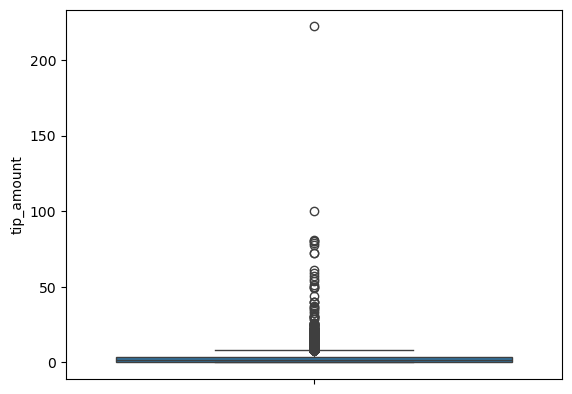

In [83]:
sns.boxplot(df['tip_amount'])

In [84]:
# drop the max value
df = df[~(df['tip_amount'] == df['tip_amount'].max())]

<Axes: xlabel='total_amount', ylabel='tip_amount'>

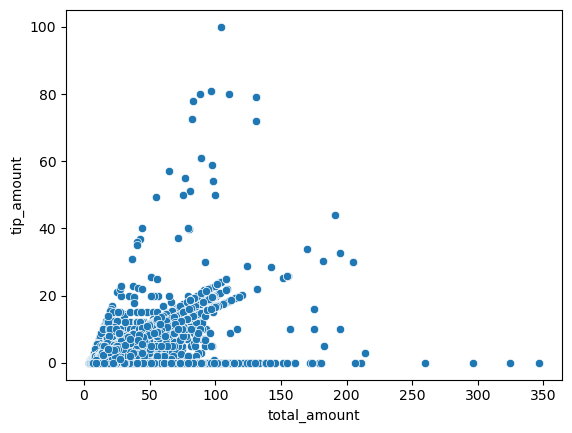

In [85]:
sns.scatterplot(df, x='total_amount', y='tip_amount')

We can see that the tip amounts are linearly proportional to the total amount in varying slopes, which might represent the automated percentages of the total amount made to be the tip. Since the outlier values are proportional to the total amount, this is not an error and therefore will not be dropped, only the one very large value is dropped.

In [86]:
calculate_diff()

### 13. `tolls_amount`
>**Description:**
>Total amount of all tolls paid in trip.
>
>Source: [Data Dictionary - LPEP Trip Records](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)
>

In [87]:
df['tolls_amount'].describe()

count    59931.000000
mean         0.123685
std          0.932391
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.050000
Name: tolls_amount, dtype: float64

In [88]:
# final df size
len(df)

59931

## Joining Taxi Zone Lookup and Taxi Zone Geography
In the [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) page, there are supporting data files which we could use for analysis, namely:
- `taxi_zone_lookup.csv` which contains more information which directly refers to the `PULocationID` and `DOLocationID` columns in our dataset. 
- `taxi_zones.shp` contains geographical data which allow us to visualize a map

In [89]:
taxi_zones = pd.read_csv('taxi_zone_lookup.csv')
taxi_zones.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

In [90]:
# join for PULocationID
df = pd.merge(df, taxi_zones, how="left", left_on="PULocationID", right_on="LocationID")
df = df.drop(columns=["LocationID"])
df = df.rename(columns={"Borough": "PU_Borough", "Zone": "PU_Zone", "service_zone": "PU_service_zone"})

# join for DOLocationID
df = pd.merge(df, taxi_zones, how="left", left_on="DOLocationID", right_on="LocationID")
df = df.drop(columns=["LocationID"])
df = df.rename(columns={"Borough": "DO_Borough", "Zone": "DO_Zone", "service_zone": "DO_service_zone"})

df.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0        2  2023-01-01 00:26:10   2023-01-01 00:37:11                  N   
1        2  2023-01-01 00:51:03   2023-01-01 00:57:49                  N   
2        1  2023-01-01 00:13:14   2023-01-01 00:19:03                  N   
3        1  2023-01-01 00:33:04   2023-01-01 00:39:02                  N   
4        2  2023-01-01 00:53:31   2023-01-01 01:11:04                  N   

  RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0        1.0           166           143                1           2.58   
1        1.0            24            43                1           1.81   
2        1.0            41           238                1           1.30   
3        1.0            41            74                1           1.10   
4        1.0            41           262                1           2.78   

   fare_amount  ...  congestion_surcharge  trip_duration  calc_amount  \
0         14.9  ...                  2.75          11.02        24.18   
1         10.7  ...                  0.00           6.77        15.84   
2          6.5  ...                  0.00           5.82        10.20   
3          6.0  ...                  0.00           5.97         8.00   
4         17.7  ...                  2.75          17.55        22.95   

   diff_amount  PU_Borough              PU_Zone PU_service_zone DO_Borough  \
0          0.0   Manhattan  Morningside Heights       Boro Zone  Manhattan   
1          0.0   Manhattan         Bloomingdale     Yellow Zone  Manhattan   
2          0.0   Manhattan       Central Harlem       Boro Zone  Manhattan   
3          0.0   Manhattan       Central Harlem       Boro Zone  Manhattan   
4          0.0   Manhattan       Central Harlem       Boro Zone  Manhattan   

                 DO_Zone  DO_service_zone  
0    Lincoln Square West      Yellow Zone  
1           Central Park      Yellow Zone  
2  Upper West Side North      Yellow Zone  
3      East Harlem North        Boro Zone  
4         Yorkville East      Yellow Zone  

[5 rows x 28 columns]

In [91]:
# Load the SHP file
taxi_path = "taxi_zones.shp"
gdf = gpd.read_file(taxi_path)
gdf = gdf.to_crs(epsg=3857)

In [92]:
gdf = pd.merge(gdf, taxi_zones, how="left", left_on="LocationID", right_on="LocationID")

In [93]:
# PICKUP geo data
gdf_PU = gdf.copy()

PU_zone_counts = df['PULocationID'].value_counts().reset_index()
PU_zone_counts.columns = ['PULocationID', 'count']

PU_zone_counts['PULocationID'] = PU_zone_counts['PULocationID'].astype(int)
gdf_PU['LocationID'] = gdf_PU['LocationID'].astype(int)

# Merge the data
gdf_PU = gdf_PU.merge(PU_zone_counts, left_on="LocationID", right_on="PULocationID")
gdf_PU = gdf_PU.drop(columns=["LocationID"])

# Replace NaN values (if any) with 0
gdf_PU['count'] = gdf_PU['count'].fillna(0)


In [94]:
# DROPOFF geo data
gdf_DO = gdf.copy()

DO_zone_counts = df['DOLocationID'].value_counts().reset_index()
DO_zone_counts.columns = ['DOLocationID', 'count']

DO_zone_counts['DOLocationID'] = DO_zone_counts['DOLocationID'].astype(int)
gdf_DO['LocationID'] = gdf_DO['LocationID'].astype(int)

# Merge the data
gdf_DO = gdf_DO.merge(DO_zone_counts, left_on="LocationID", right_on="DOLocationID")
gdf_DO = gdf_DO.drop(columns=["LocationID"])

# Replace NaN values (if any) with 0
gdf_DO['count'] = gdf_DO['count'].fillna(0)


## EDA

In [95]:
# illegal street hail trips by green taxis in yellow zone
df[(df["PU_service_zone"]=="Yellow Zone")]['improvement_surcharge']

1        1.0
6        1.0
8        1.0
50       1.0
154      0.3
        ... 
59770    1.0
59784    0.3
59819    1.0
59825    1.0
59896    1.0
Name: improvement_surcharge, Length: 3814, dtype: float64

In [96]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'payment_type', 'trip_type', 'congestion_surcharge', 'trip_duration',
       'calc_amount', 'diff_amount', 'PU_Borough', 'PU_Zone',
       'PU_service_zone', 'DO_Borough', 'DO_Zone', 'DO_service_zone'],
      dtype='object')

In [97]:
df[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration']].describe()

passenger_count  trip_distance   fare_amount    tip_amount  \
count     59931.000000   59931.000000  59931.000000  59931.000000   
mean          1.329913       2.635035     15.548187      2.088511   
std           0.990502       2.573349     11.105436      2.832920   
min           1.000000       0.000000      3.000000      0.000000   
25%           1.000000       1.190000      8.600000      0.000000   
50%           1.000000       1.860000     12.800000      1.600000   
75%           1.000000       3.110000     18.400000      3.280000   
max           6.000000      57.090000    322.900000    100.000000   

       tolls_amount  total_amount  trip_duration  
count  59931.000000  59931.000000   59931.000000  
mean       0.123685     20.797059      13.177623  
std        0.932391     13.227328       9.419438  
min        0.000000      3.500000       0.020000  
25%        0.000000     12.600000       7.170000  
50%        0.000000     17.290000      11.050000  
75%        0.000000     25.070000      16.530000  
max       36.050000    347.000000     182.530000

<Axes: xlabel='passenger_count', ylabel='count'>

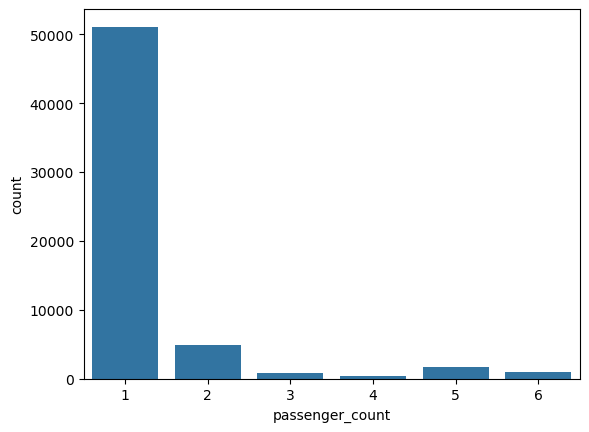

In [98]:
sns.barplot(df['passenger_count'].value_counts())

## Payment Preference Analysis

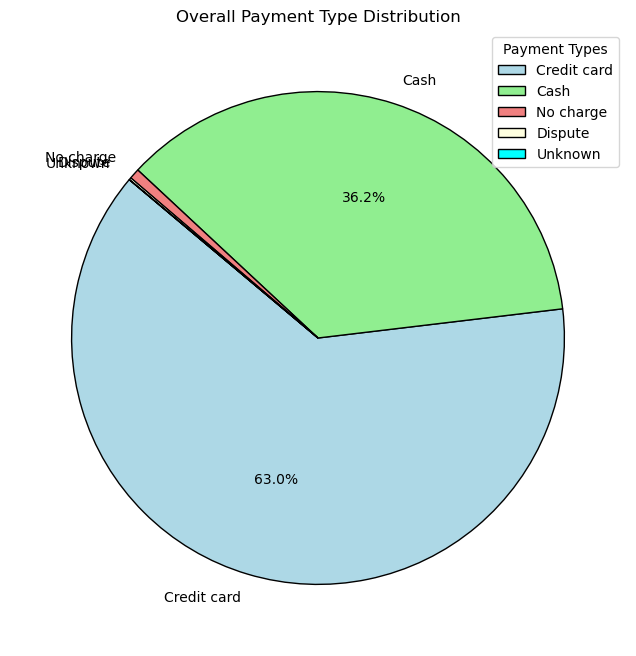

In [99]:
# overall Payment type pie chart
payment_counts = df['payment_type'].value_counts()
payment_names = ['Credit card', 'Cash', 'No charge', 'Dispute', 'Unknown']


# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    payment_counts, 
    labels=payment_names, 
    labeldistance=1.1,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',  # Hide small percentages
    colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'cyan'], 
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}
)

# Add a legend
ax.legend(wedges, payment_names, title="Payment Types", loc="best")

# Title
plt.title("Overall Payment Type Distribution")
plt.show()

We find that there is 36.2 % of all boro taxi customers paying cash, which is still a large proportion for the TLC to move completely to pre-arranged trips.

Next, we compare the proportion of credit card payments for Manhattan compared to the Outer Boroughs, using the two-proportion z-test

In [100]:
df_manhattan = df[(df['PU_Borough']=='Manhattan')&(df['DO_Borough']=='Manhattan')]
df_outer = df[~((df['PU_Borough']=='Manhattan')&(df['DO_Borough']=='Manhattan'))]

In [101]:
len(df_manhattan[df_manhattan['payment_type']==1])

24112

In [102]:
len(df_manhattan)

34326

In [103]:
len(df_outer[df_outer['payment_type']==1])

13646

In [104]:
len(df_outer)

25605

In [105]:

# Number of successes (credit card users) in each group
count = np.array([24112, 13646])  

# Total sample sizes in each group
nobs = np.array([len(df_manhattan), len(df_outer)])  


In [106]:
# Perform two-proportion z-test
stat, p = proportions_ztest(count, nobs)

print(f"Z-Test Statistic: {stat:.4f}, p-value: {p:.4f}")

# Interpretation
if p < 0.05:
    print("Significant difference in credit card usage between cities! (Reject H0)")
else:
    print("No significant difference in credit card usage. (Fail to reject H0)")

Z-Test Statistic: 42.5157, p-value: 0.0000
Significant difference in credit card usage between cities! (Reject H0)


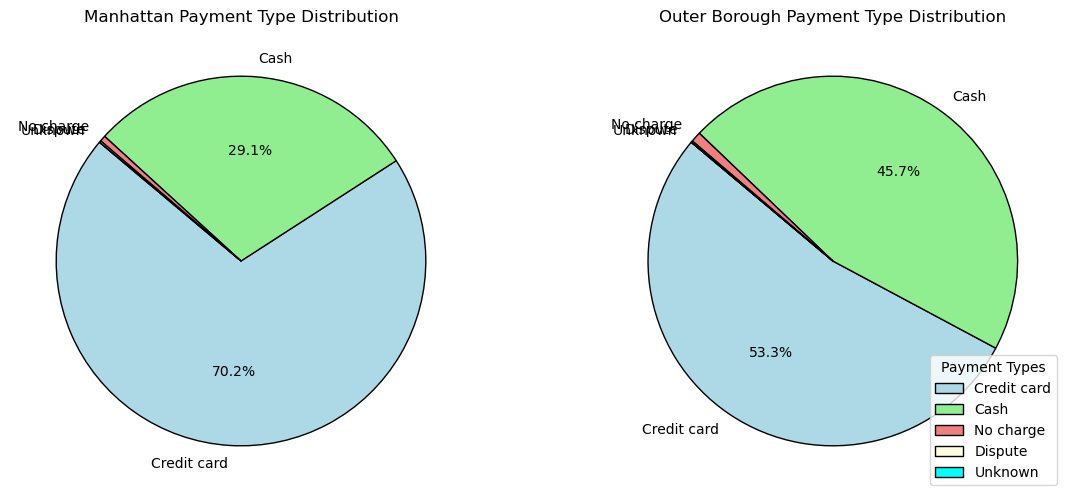

In [107]:
payment_names = ['Credit card', 'Cash', 'No charge', 'Dispute', 'Unknown']

# manhattan Pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
wedges, texts, autotexts = axes[0].pie(
    df_manhattan['payment_type'].value_counts(), 
    labels=payment_names, 
    autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',  # Hide small percentages
    colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'cyan'], 
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}
)

axes[0].set_title("Manhattan Payment Type Distribution")

# outer borough Pie chart
wedges, texts, autotexts = axes[1].pie(
    df_outer['payment_type'].value_counts(), 
    labels=payment_names, 
    autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',  # Hide small percentages
    colors=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'cyan'], 
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}
)

axes[1].legend(wedges, payment_names, title="Payment Types", loc="lower right")
axes[1].set_title("Outer Borough Payment Type Distribution")


plt.show()

## Fare and Surge Pricing Analysis

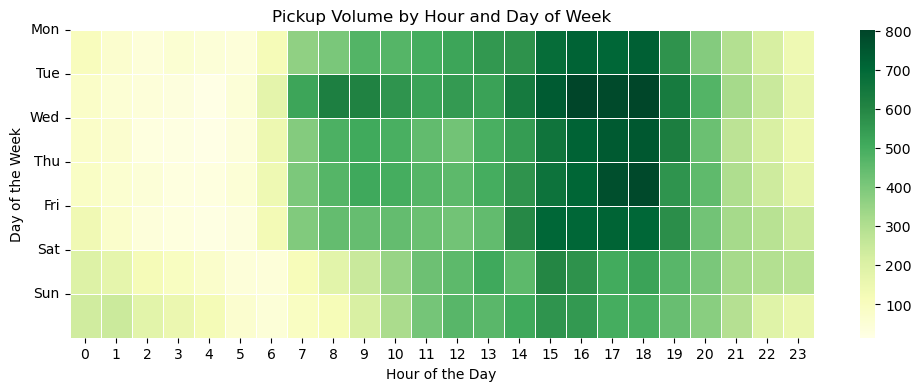

In [108]:
# Pickup Trip Volume heatmap
# Extract hour and day of the week
df["PU_hour"] = df["lpep_pickup_datetime"].dt.hour
df["PU_day"] = df["lpep_pickup_datetime"].dt.dayofweek  # Monday=0, Sunday=6

# Count trips per day and hour
PU_heatmap_data = df.groupby(["PU_day", "PU_hour"]).size().unstack()

# Plot heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(PU_heatmap_data, cmap="YlGn", linewidths=0.5)

# Customize labels
plt.title("Pickup Volume by Hour and Day of Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.yticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

plt.show()

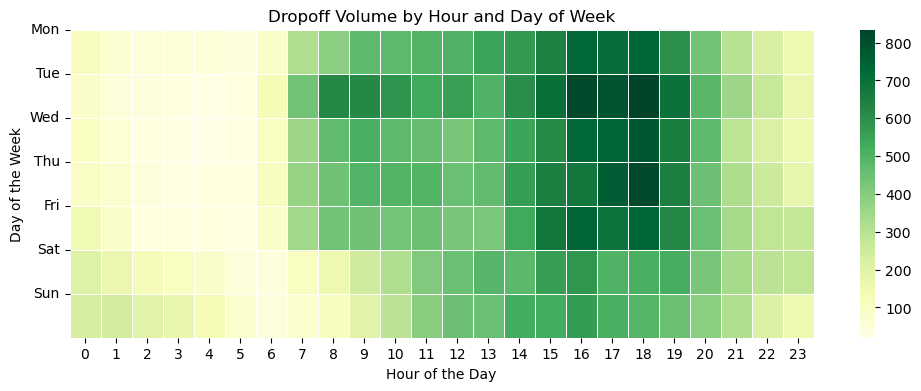

In [109]:
# Dropoff Trip Volume heatmap
# Extract hour and day of the week
df["DO_hour"] = df["lpep_dropoff_datetime"].dt.hour
df["DO_day"] = df["lpep_dropoff_datetime"].dt.dayofweek  # Monday=0, Sunday=6

# Count trips per day and hour
DO_heatmap_data = df.groupby(["DO_day", "DO_hour"]).size().unstack()

# Plot heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(DO_heatmap_data, cmap="YlGn", linewidths=0.5)

# Customize labels
plt.title("Dropoff Volume by Hour and Day of Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.yticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

plt.show()

The heatmaps show the times when the most pickups and dropoffs occur, we can conclude that:
- The trends in pickup and dropoff volume are very similar, this could be due to the trip duration not going above 1 hour (Q3= 16.5 minutes)
- There is the highest number of trips at 3 pm - 8 pm on weekdays, and at 3 pm - 5 pm on weekends

We want to investigate the implementation of surge pricing, the fare rules which apply are:

- \$1.00 overnight surcharge 8pm to 6am.
- \$2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.

In [110]:
# filter weekends and weekdays
df_weekend = df[(df["PU_day"]>4)]
df_weekday = df[(df["PU_day"]<=4)]

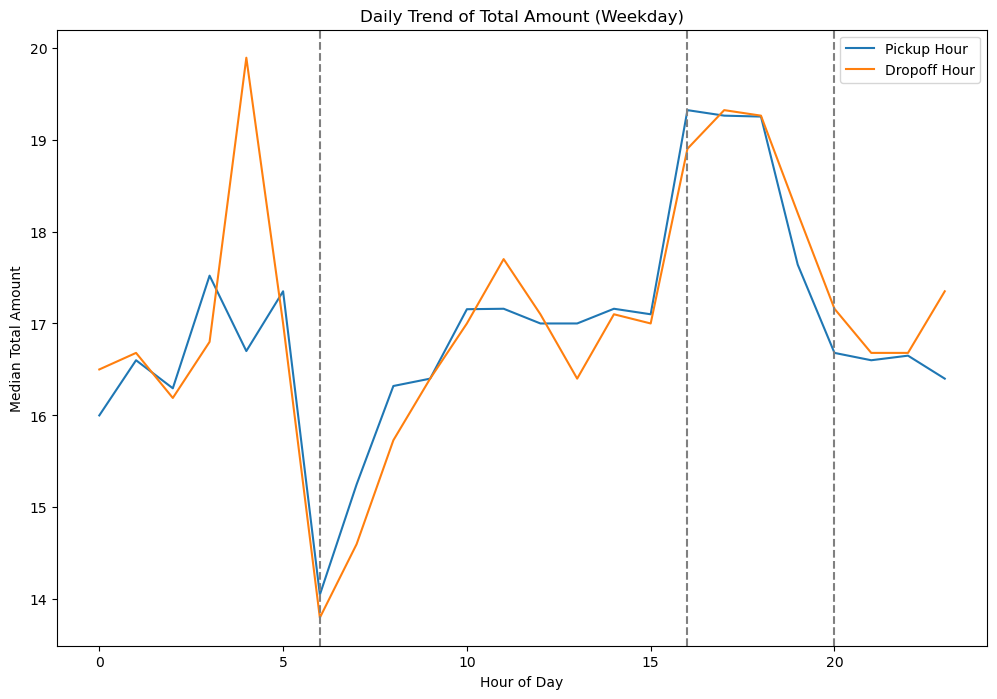

In [111]:
PUamount_over_time = df_weekday.groupby(["PU_hour"])["total_amount"].median()
DOamount_over_time = df_weekday.groupby(["DO_hour"])["total_amount"].median()

plt.figure(figsize=(12, 8))
sns.lineplot(PUamount_over_time, label='Pickup Hour')
sns.lineplot(DOamount_over_time, label='Dropoff Hour')
plt.ylabel('Median Total Amount')
plt.xlabel('Hour of Day')
plt.axvline(x=6, ls='--', color='grey')
plt.axvline(x=16, ls='--', color='grey')
plt.axvline(x=20, ls='--', color='grey')
plt.title('Daily Trend of Total Amount (Weekday)')
plt.legend
plt.show()

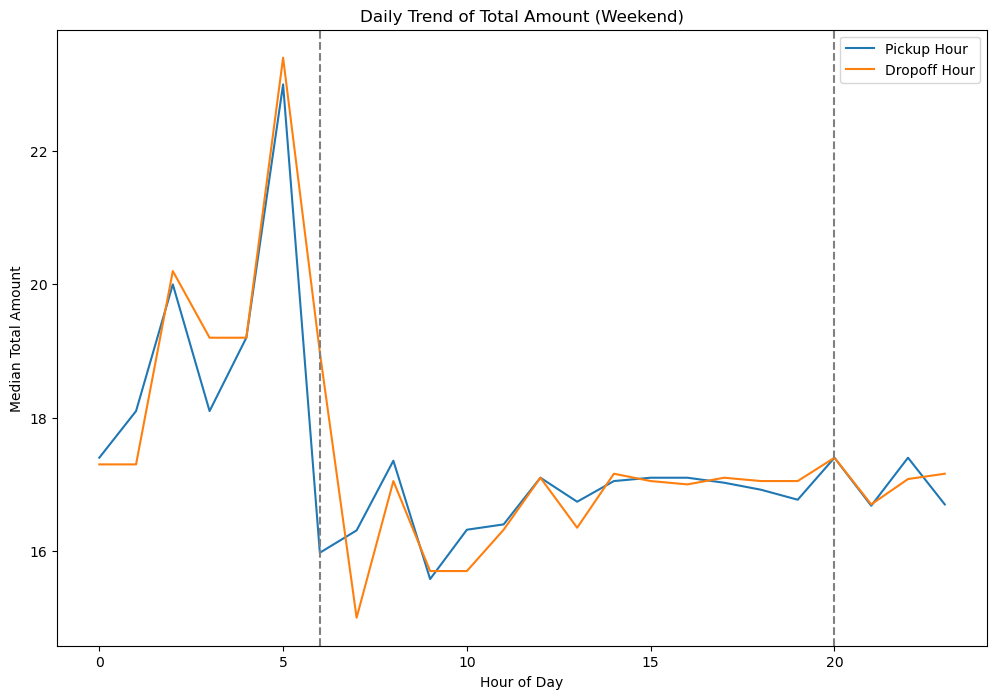

In [112]:
PUamount_over_time = df_weekend.groupby(["PU_hour"])["total_amount"].median()
DOamount_over_time = df_weekend.groupby(["DO_hour"])["total_amount"].median()

plt.figure(figsize=(12, 8))
sns.lineplot(PUamount_over_time, label='Pickup Hour')
sns.lineplot(DOamount_over_time, label='Dropoff Hour')
plt.ylabel('Median Total Amount')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Daily Trend of Total Amount (Weekend)')
plt.legend
plt.show()

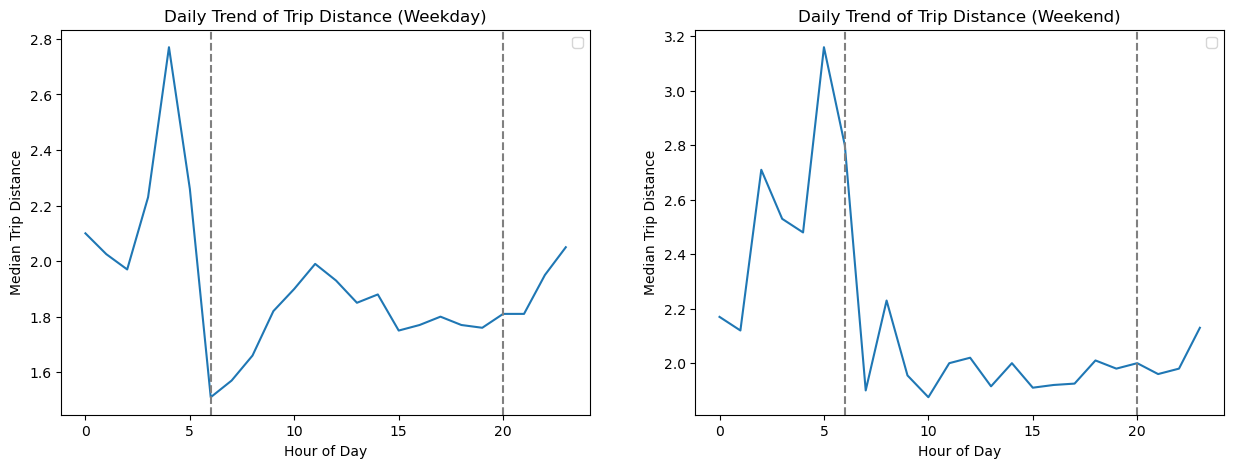

In [113]:
weekday_distance_over_time = df_weekday.groupby(["DO_hour"])["trip_distance"].median()
weekend_distance_over_time = df_weekend.groupby(["DO_hour"])["trip_distance"].median()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(weekday_distance_over_time)
plt.ylabel('Median Trip Distance')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Daily Trend of Trip Distance (Weekday)')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(weekend_distance_over_time)
plt.ylabel('Median Trip Distance')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Daily Trend of Trip Distance (Weekend)')
plt.legend()

plt.show()

- Highest total amount at 4-5 am on weekdays (dropoff) and 5-6 am on weekends (pickup and dropoff)
- From Median Trip Distance lineplot, we see that the increase in total amount is due to the increase in trip distance, except for during rush hour during weekdays, which could be attributed to surge pricing

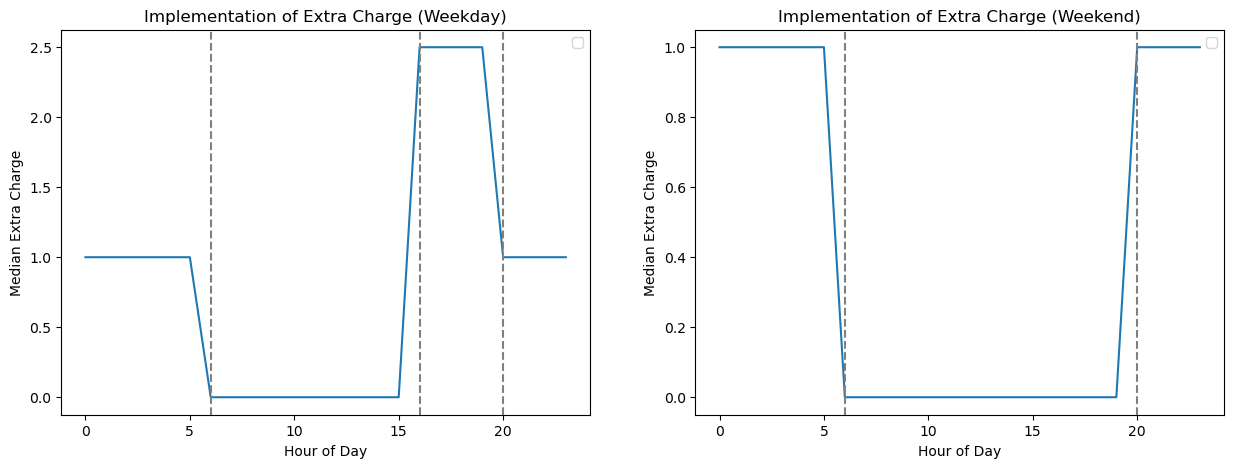

In [114]:
weekday_overnight_over_time = df_weekday.groupby(["DO_hour"])["extra"].median()
weekend_overnight_over_time = df_weekend.groupby(["DO_hour"])["extra"].median()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(weekday_overnight_over_time)
plt.ylabel('Median Extra Charge')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=16, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Implementation of Extra Charge (Weekday)')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(weekend_overnight_over_time)
plt.ylabel('Median Extra Charge')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Implementation of Extra Charge (Weekend)')
plt.legend()

plt.show()

In [115]:
df[(df['DO_hour']>=4)&(df['DO_hour']<=5)]

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
174          2  2023-01-01 03:49:14   2023-01-01 04:07:23                  N   
186          2  2023-01-01 04:20:54   2023-01-01 04:34:30                  N   
191          2  2023-01-01 03:31:30   2023-01-01 04:01:04                  N   
199          2  2023-01-01 03:45:57   2023-01-01 04:05:20                  N   
207          2  2023-01-01 03:22:41   2023-01-01 04:14:13                  N   
...        ...                  ...                   ...                ...   
57901        2  2023-01-31 04:59:49   2023-01-31 05:23:21                  N   
57904        2  2023-01-31 05:30:18   2023-01-31 05:34:18                  N   
57906        1  2023-01-31 05:25:04   2023-01-31 05:33:43                  N   
57908        2  2023-01-31 05:46:20   2023-01-31 05:52:13                  N   
57910        2  2023-01-31 05:41:46   2023-01-31 05:50:26                  N   

      RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
174          1.0           129            92                1           6.84   
186          1.0           223           193                1           2.34   
191          1.0           256           129                1           6.65   
199          1.0           256           129                1           5.52   
207          1.0           129           129                2           5.29   
...          ...           ...           ...              ...            ...   
57901        3.0            65             1                2          15.08   
57904        1.0            75            74                1           1.39   
57906        1.0            74            43                1           1.40   
57908        1.0            74            41                1           0.75   
57910        1.0            74           152                1           1.78   

       fare_amount  ...  PU_Borough                      PU_Zone  \
174           30.3  ...      Queens              Jackson Heights   
186           14.9  ...      Queens                     Steinway   
191           35.2  ...    Brooklyn    Williamsburg (South Side)   
199           27.5  ...    Brooklyn    Williamsburg (South Side)   
207           46.4  ...      Queens              Jackson Heights   
...            ...  ...         ...                          ...   
57901         76.9  ...    Brooklyn  Downtown Brooklyn/MetroTech   
57904          7.9  ...   Manhattan            East Harlem South   
57906          9.3  ...   Manhattan            East Harlem North   
57908          7.9  ...   Manhattan            East Harlem North   
57910         11.4  ...   Manhattan            East Harlem North   

       PU_service_zone  DO_Borough                  DO_Zone  DO_service_zone  \
174          Boro Zone      Queens                 Flushing        Boro Zone   
186          Boro Zone      Queens  Queensbridge/Ravenswood        Boro Zone   
191          Boro Zone      Queens          Jackson Heights        Boro Zone   
199          Boro Zone      Queens          Jackson Heights        Boro Zone   
207          Boro Zone      Queens          Jackson Heights        Boro Zone   
...                ...         ...                      ...              ...   
57901        Boro Zone         EWR           Newark Airport              EWR   
57904        Boro Zone   Manhattan        East Harlem North        Boro Zone   
57906        Boro Zone   Manhattan             Central Park      Yellow Zone   
57908        Boro Zone   Manhattan           Central Harlem        Boro Zone   
57910        Boro Zone   Manhattan           Manhattanville        Boro Zone   

      PU_hour PU_day  DO_hour  DO_day  
174         3      6        4       6  
186         4      6        4       6  
191         3      6        4       6  
199         3      6        4       6  
207         3      6        4       6  
...       ...    ...      ...     ...  
57901       4      1      

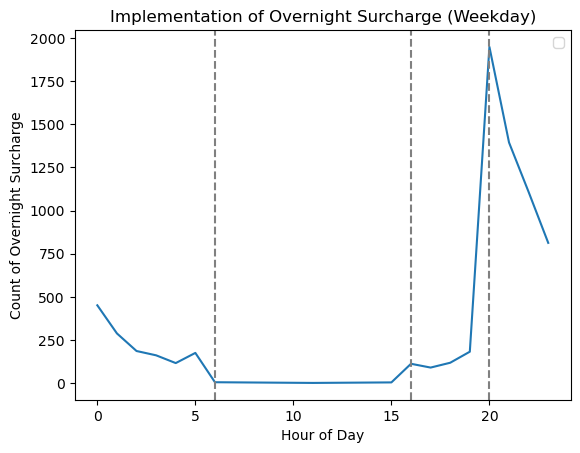

In [116]:
overnight_weekday = df_weekday[df_weekday['extra']==1]['PU_hour'].value_counts()

sns.lineplot(overnight_weekday)
plt.ylabel('Count of Overnight Surcharge')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=16, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Implementation of Overnight Surcharge (Weekday)')
plt.legend()
plt.show()

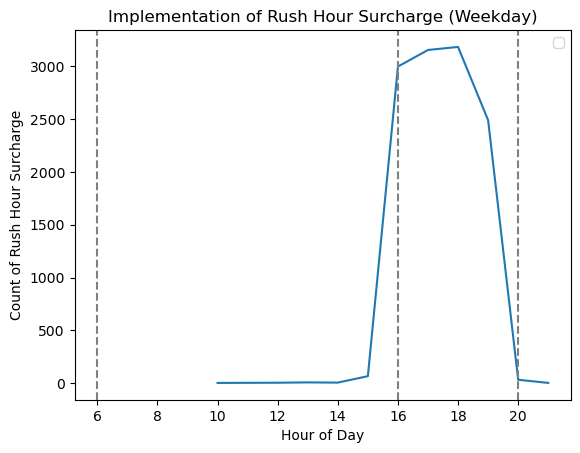

In [117]:
rushhour = df_weekday[df_weekday['extra']==2.5]['PU_hour'].value_counts()

sns.lineplot(rushhour)
plt.ylabel('Count of Rush Hour Surcharge')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=16, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Implementation of Rush Hour Surcharge (Weekday)')
plt.legend()
plt.show()

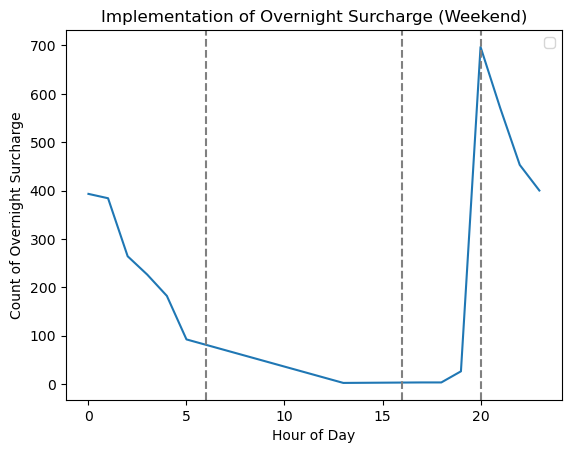

In [118]:
overnight_weekend = df_weekend[df_weekend['extra']==1]['PU_hour'].value_counts()

sns.lineplot(overnight_weekend)
plt.ylabel('Count of Overnight Surcharge')
plt.xlabel('Hour of Day')
plt.axvline(x=20, ls='--', color='grey')
plt.axvline(x=16, ls='--', color='grey')
plt.axvline(x=6, ls='--', color='grey')
plt.title('Implementation of Overnight Surcharge (Weekend)')
plt.legend()
plt.show()

## Map Analysis for Popular Zones

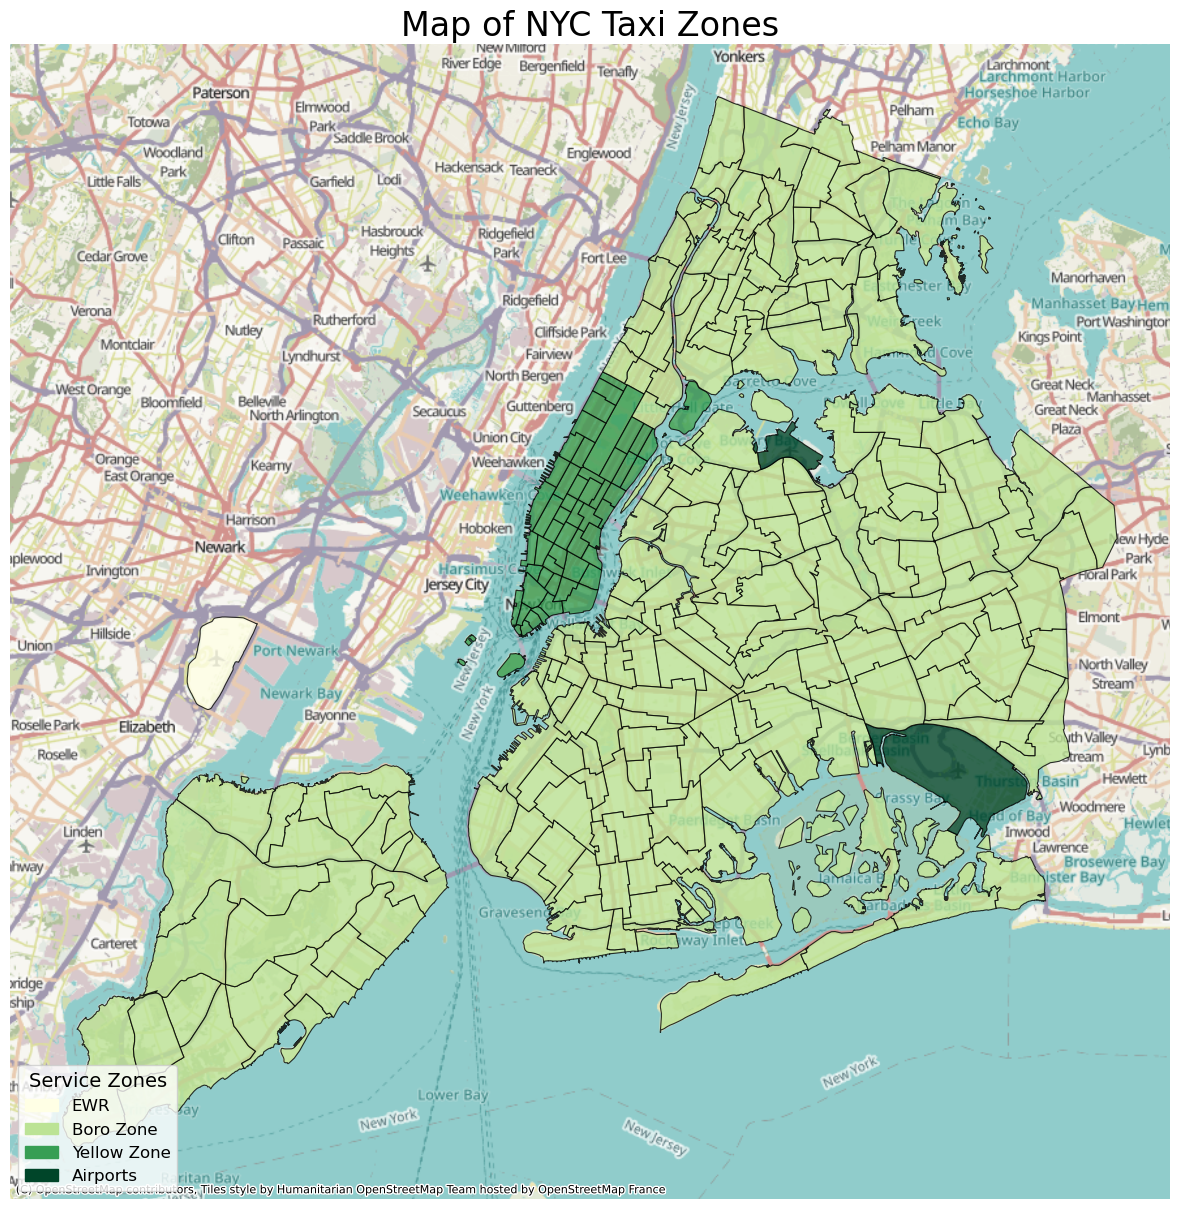

In [119]:
# Boro and Yellow Taxi zones map


fig, ax = plt.subplots(1, 1, figsize=(15, 15))

unique_zones = gdf['service_zone'].unique()
colormap = cm.get_cmap('YlGn', len(unique_zones))  # Get a colormap with as many colors as unique zones
zone_to_color = {zone: colormap(i) for i, zone in enumerate(unique_zones)}

gdf['color'] = gdf['service_zone'].map(zone_to_color)

gdf.plot(
    color=gdf['color'],
    linewidth=0.8,         # Line width for boundaries
    edgecolor='k',         # Boundary color
    alpha=0.8,             # Transparency
    ax=ax
)

# basemap
ctx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),  # CRS definition for the basemap
)

# legend
legend_handles = [
    mpatches.Patch(color=zone_to_color[zone], label=zone)
    for zone in unique_zones
]

ax.legend(
    handles=legend_handles,
    title='Service Zones',
    title_fontsize=14,
    fontsize=12,
    loc='lower left', 
)



# Customize the plot
ax.set_axis_off()
ax.set(title='Map of NYC Taxi Zones')
ax.title.set_size(24)

plt.show()

In [120]:
PU_zone_counts = PU_zone_counts.merge(df[["PULocationID", "PU_Zone", "PU_Borough", "PU_service_zone"]].drop_duplicates(subset=["PULocationID"]), how="left", on="PULocationID")


In [121]:
PU_zone_counts.sort_values(by="count", ascending=False).head(10)

PULocationID  count                   PU_Zone PU_Borough PU_service_zone
0            74  12693         East Harlem North  Manhattan       Boro Zone
1            75   8654         East Harlem South  Manhattan       Boro Zone
2            95   3657              Forest Hills     Queens       Boro Zone
3            41   3653            Central Harlem  Manhattan       Boro Zone
4           166   3554       Morningside Heights  Manhattan       Boro Zone
5            43   2826              Central Park  Manhattan     Yellow Zone
6            82   2758                  Elmhurst     Queens       Boro Zone
7            97   2060               Fort Greene   Brooklyn       Boro Zone
8             7   1607                   Astoria     Queens       Boro Zone
9           244   1585  Washington Heights South  Manhattan       Boro Zone

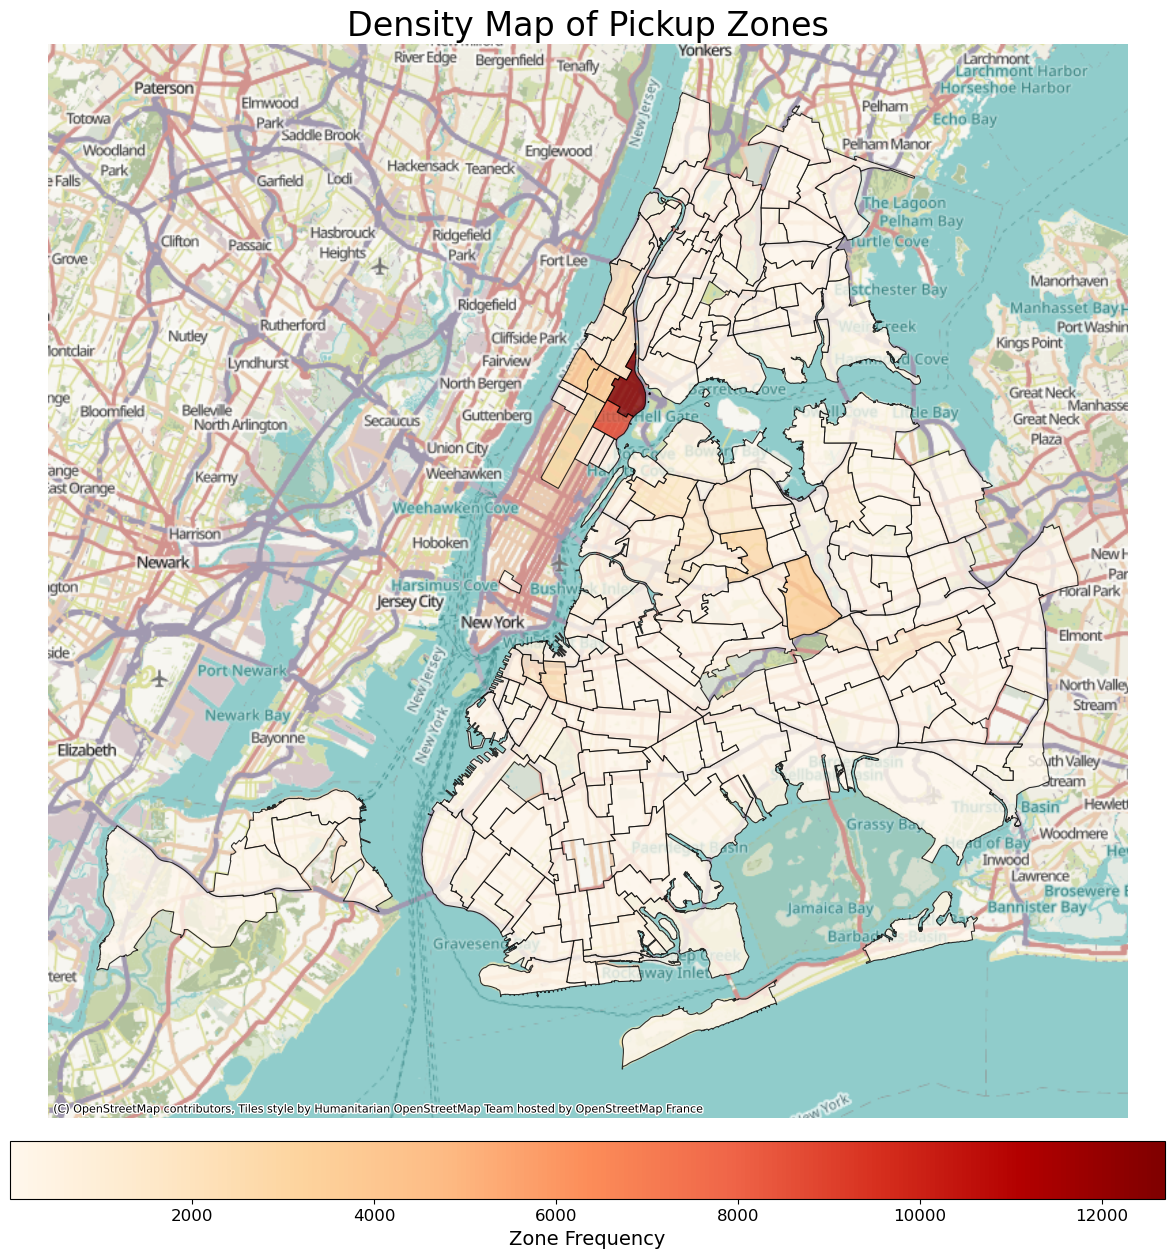

In [122]:
# Plot Pickup Density Map

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_PU.plot(
    column='count',  # The column to use for coloring
    cmap='OrRd',     # Color map (e.g., OrRd, Blues, Viridis)
    linewidth=0.8,   # Line width for boundaries
    edgecolor='k',   # Boundary color
    alpha=0.8,       # Transparency
    ax=ax
)

# Add a basemap
ctx.add_basemap(
    ax,
    # CRS definition (without the line below, the map is incorrect)
    crs=gdf.crs.to_string(),
)


# Customize the plot
ax.set_axis_off()  # Remove axes
ax.set(title='Density Map of Pickup Zones')
ax.title.set_size(24)

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=gdf_PU['count'].min(), vmax=gdf_PU['count'].max()))
sm._A = []  # Empty array for the ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.02)
cbar.set_label('Zone Frequency', size=14)
cbar.ax.tick_params(labelsize=12)

plt.show()

In [123]:
DO_zone_counts = DO_zone_counts.merge(df[["DOLocationID", "DO_Zone", "DO_Borough", "DO_service_zone"]].drop_duplicates(subset=["DOLocationID"]), how="left", on="DOLocationID")


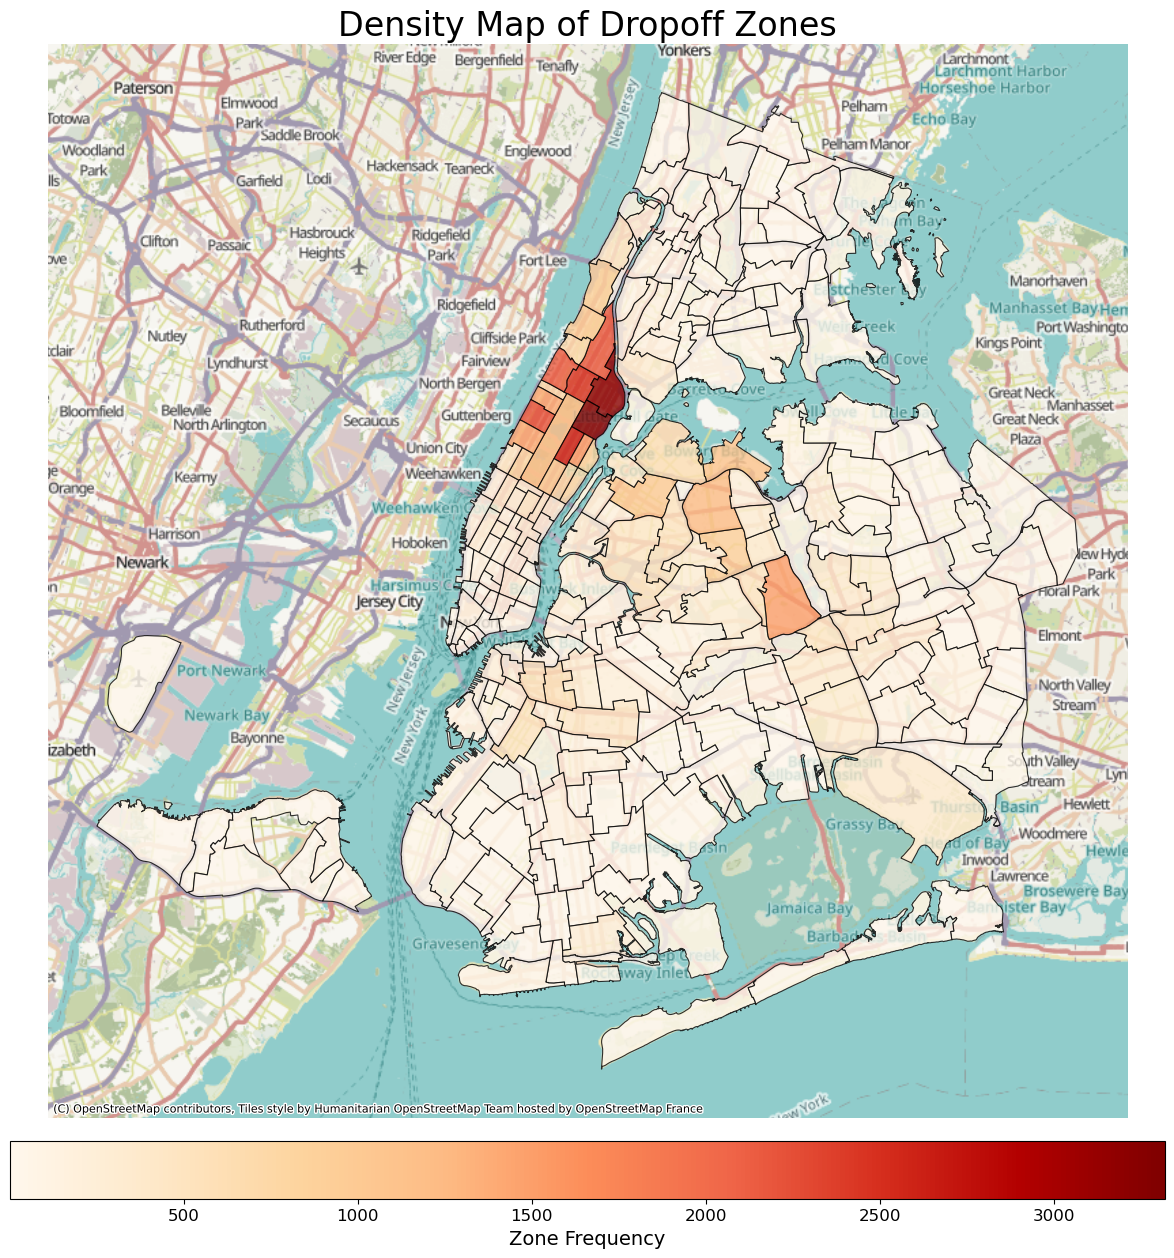

In [124]:
# Plot Dropoff Density Map

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_DO.plot(
    column='count',
    cmap='OrRd',     
    linewidth=0.8,   
    edgecolor='k',   
    alpha=0.8,       
    ax=ax
)

# Add a basemap
ctx.add_basemap(
    ax,
    # CRS definition (without the line below, the map is incorrect)
    crs=gdf.crs.to_string(),
)


# Customize the plot
ax.set_axis_off()  # Remove axes
ax.set(title='Density Map of Dropoff Zones')
ax.title.set_size(24)

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=gdf_DO['count'].min(), vmax=gdf_DO['count'].max()))
sm._A = []  # Empty array for the ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.02)
cbar.set_label('Zone Frequency', size=14)
cbar.ax.tick_params(labelsize=12)

plt.show()

In [125]:
pd.DataFrame(PU_zone_counts.groupby('PU_Borough')['count'].sum().sort_values(ascending=False))

count
PU_Borough          
Manhattan      36583
Queens         15743
Brooklyn        7011
Bronx            518
Unknown           46
Staten Island      9

In [126]:
PU_zone_counts.groupby('PU_service_zone')['count'].sum()

PU_service_zone
Airports          13
Boro Zone      56037
Yellow Zone     3814
Name: count, dtype: int64

As we can see from the density map of the pickup zones, there are a few pickups in the Pre-Arranged Exclusionary Zone. These trips under the SHL Pilot Program will incur a fine:
>You will be penalized under TLC Rule 80-19(b)(1)(first violation carries a $500 fine and suspension). Further, the Commissioner of the TLC reserves the right to revoke your SHL Permit.
>
>Source: [SHL Pilot Program Frequently Asked Questions](https://www.nyc.gov/site/tlc/about/shl-pilot-program-faq.page)

However, the most popular pickup zones are in the northern part of manhattan closest to the boundary of the Pre-Arranged Exclusionary Zone.

In [127]:
gdf.sample(10)

OBJECTID  Shape_Leng  Shape_Area                           zone  \
249       250    0.079626    0.000241  Westchester Village/Unionport   
231       232    0.061471    0.000216        Two Bridges/Seward Park   
168       169    0.060105    0.000146                     Mount Hope   
5           6    0.150491    0.000606        Arrochar/Fort Wadsworth   
111       112    0.107268    0.000462                     Greenpoint   
222       223    0.166022    0.000764                       Steinway   
84         85    0.057475    0.000144                        Erasmus   
73         74    0.110291    0.000295              East Harlem North   
203       204    0.101912    0.000641              Rossville/Woodrow   
152       153    0.024737    0.000032                    Marble Hill   

     LocationID        borough  \
249         250          Bronx   
231         232      Manhattan   
168         169          Bronx   
5             6  Staten Island   
111         112       Brooklyn   
222         223         Queens   
84           85       Brooklyn   
73           74      Manhattan   
203         204  Staten Island   
152         153      Manhattan   

                                              geometry        Borough  \
249  POLYGON ((-8220446.897 4988648.627, -8220341.1...          Bronx   
231  POLYGON ((-8235010.197 4971001.681, -8234916.1...      Manhattan   
168  POLYGON ((-8226306.185 4990999.208, -8226358.4...          Bronx   
5    POLYGON ((-8244730.386 4953841.873, -8244711.7...  Staten Island   
111  MULTIPOLYGON (((-8232565.655 4973936.975, -823...       Brooklyn   
222  POLYGON ((-8227233.382 4981442.494, -8226789.9...         Queens   
84   POLYGON ((-8231760.081 4961673.784, -8231746.0...       Brooklyn   
73   MULTIPOLYGON (((-8230273.625 4985314.854, -823...      Manhattan   
203  POLYGON ((-8260269.664 4947016.276, -8260230.1...  Staten Island   
152  POLYGON ((-8227252.349 4994026.992, -8227281.2...      Manhattan   

                              Zone service_zone  \
249  Westchester Village/Unionport    Boro Zone   
231        Two Bridges/Seward Park  Yellow Zone   
168                     Mount Hope    Boro Zone   
5          Arrochar/Fort Wadsworth    Boro Zone   
111                     Greenpoint    Boro Zone   
222                       Steinway    Boro Zone   
84                         Erasmus    Boro Zone   
73               East Harlem North    Boro Zone   
203              Rossville/Woodrow    Boro Zone   
152                    Marble Hill    Boro Zone   

                                                 color  
249  (0.7359477124183007, 0.8915032679738563, 0.584...  
231  (0.21568627450980393, 0.6196078431372549, 0.33...  
168  (0.7359477124183007, 0.8915032679738563, 0.584...  
5    (0.7359477124183007, 0.8915032679738563, 0.584...  
111  (0.7359477124183007, 0.8915032679738563, 0.584...  
222  (0.7359477124183007, 0.8915032679738563, 0.584...  
84   (0.7359477124183007, 0.8915032679738563, 0.584...  
73   (0.7359477124183007, 0.8915032679738563, 0.584...  
203  (0.7359477124183007, 0.8915032679738563, 0.584...  
152  (0.7359477124183007, 0.8915032679738563, 0.584...

## Recommendations

From the analysis done above, we can conlcude some recommendations for the SHL Pilot team for their pilot program to replace the street-hail trips with pre-arranged trips only:

- **Offer a Cash-on-Arrival system for SHL taxis:** There is still a substantial proportion of customers, specifically in trips to or from outer boroughs which still pay using cash as of the end of January 2023. There will be a segment of customers which will not be served if the transition to app-based pre-arranged trips using cashless payments only.

- **Use Flat-Fare Guidelines for Pre-Arranged Trip Fares:** This will guarantee that the price will be more competitive than FHV companies like Lyft or Uber
  
- **Give Pilot Program Licenses to Bases Operating in Upper Manhattan:** The highest number of trips made by the boro taxis are still in Manhattan near the border between Yellow Taxi zones. For a smoother transition in pilot program, the SHL pilot participants can be deployed first in the busiest areas, in order to get data to compare for performance.